In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm import tqdm, tqdm_notebook
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

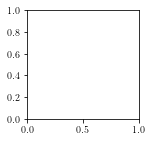

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
job_dir = 'ecoC01B05_T1_psi-0a'
table_name = 'ecoC01B05_T1'

In [4]:
# show phase map of theta-phi, load date
importlib.reload(spf_tb)

t_headle = '(.*?).pickle'
t_path = os.listdir(os.path.join(PWD, job_dir))
filename_list = [filename for filename in os.listdir(os.path.join(PWD, job_dir)) 
                 if re.match(t_headle, filename) is not None]
ini_theta_list = []
ini_phi_list = []
lst_eta_list = []
theta_max_fre_list = []
phi_max_fre_list = []
psi_max_fre_list = []
eta_max_fre_list = []
pickle_path_list = []
idx_list = []
for i0, tname in enumerate(tqdm_notebook(filename_list[:])):
    tpath = os.path.join(PWD, job_dir, tname)
    with open(tpath, 'rb') as handle:
        tpick = pickle.load(handle)
    ini_theta_list.append(tpick['ini_theta'])
    ini_phi_list.append(tpick['ini_phi'])
    lst_eta_list.append(tpick['Table_eta'][-1])
    pickle_path_list.append(tpath)
    idx_list.append(i0)
    
    # fft rule
    tx = tpick['Table_t']
    tmin = np.max((0, tx.max() - 1000))
    idx = tx > tmin
#     pick_fre = np.min((spf_tb.get_major_fre(tpick['Table_t'], tpick['Table_theta']), 
#                        spf_tb.get_major_fre(tpick['Table_t'], tpick['Table_phi']), 
#                        spf_tb.get_major_fre(tpick['Table_t'], tpick['Table_psi']), 
#                        spf_tb.get_major_fre(tpick['Table_t'], tpick['Table_eta']), ))
#     tmin = tx.max() - 1 / pick_fre * 10
#     idx = np.logical_and(np.hstack((True, np.diff(tx)>0)), tx > tmin)
    theta_max_fre_list.append(spf_tb.get_major_fre(tx[idx], tpick['Table_theta'][idx]))
    phi_max_fre_list.append(spf_tb.get_major_fre(tx[idx], tpick['Table_phi'][idx]))
    psi_max_fre_list.append(spf_tb.get_major_fre(tx[idx], tpick['Table_psi'][idx]))
    eta_max_fre_list.append(spf_tb.get_major_fre(tx[idx], tpick['Table_eta'][idx]))

data0 = pd.DataFrame({'ini_theta': np.around(ini_theta_list, 3), 
                 'ini_phi': np.around(ini_phi_list, 3), 
                 'lst_eta': np.around(lst_eta_list, 3), 
                 'theta_max_fre': theta_max_fre_list, 
                 'phi_max_fre': phi_max_fre_list, 
                 'psi_max_fre': psi_max_fre_list, 
                 'eta_max_fre': eta_max_fre_list, 
                 'data_idx': idx_list })
data = data0.pivot_table(index=['ini_theta'], columns=['ini_phi'])
lst_eta = data.lst_eta
theta_max_fre = data.theta_max_fre
phi_max_fre = data.phi_max_fre
psi_max_fre = data.psi_max_fre
eta_max_fre = data.eta_max_fre
data_idx = data.data_idx.fillna(-1).astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [5]:
# check if the 3D parameter space is been traversed or not 
do_check = False
if do_check:
    t_headle = '(.*?).pickle'
    t_path = os.listdir(os.path.join(PWD, job_dir))
    filename_list = [filename for filename in os.listdir(os.path.join(PWD, job_dir)) 
                     if re.match(t_headle, filename) is not None]
    ttheta = []
    tphi = []
    tpsi = []
    for i0, tname in enumerate(tqdm_notebook(filename_list[:])):
        tpath = os.path.join(PWD, job_dir, tname)
        with open(tpath, 'rb') as handle:
            tpick = pickle.load(handle)
        ttheta.append(tpick['Table_theta'])
        tphi.append(tpick['Table_phi'])
        tpsi.append(tpick['Table_psi'])

    ttheta, tphi, tpsi = np.hstack(ttheta), np.hstack(tphi), np.hstack(tpsi)
    from evtk.hl import pointsToVTK
    vtu_name = '/home/zhangji/check_th_ph_ps_%s' % job_dir
    pointsToVTK(vtu_name, 
                ttheta, tphi, tpsi, 
                data={'th_ph_ps': ttheta})
    print('save theta_phi_psi infomation to %s' % vtu_name)

In [6]:
# sort phase map of theta-phi using the name beging with pick frequience
importlib.reload(spf_tb)

# clear dir
dirpath = os.path.join(PWD, job_dir, 'th_ph_fft')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    import shutil
    shutil.rmtree(dirpath)
    print('remove folder %s' % dirpath)
os.makedirs(dirpath)
print('make folder %s' % dirpath)

for tname in tqdm_notebook(filename_list[:]):
    tpath = os.path.join(PWD, job_dir, tname)
    with open(tpath, 'rb') as handle:
        tpick = pickle.load(handle)
    Table_t = tpick['Table_t']
    Table_dt = tpick['Table_dt']
    Table_X = tpick['Table_X']
    Table_P = tpick['Table_P']
    Table_P2 = tpick['Table_P2']
    Table_theta = tpick['Table_theta']
    Table_phi = tpick['Table_phi']
    Table_psi = tpick['Table_psi']
    Table_eta = tpick['Table_eta']
    
    tmin = np.max((0, Table_t.max() - 1000))
    idx = Table_t > tmin    
    freq_pk = spf_tb.get_major_fre(Table_t[idx], Table_theta[idx])
    idx = Table_t > (Table_t.max() - 1 / freq_pk * 10)
    save_name = 'fre%.5f_%s.jpg' % (freq_pk, os.path.splitext(os.path.basename(tname))[0])
    fig = spf_tb.light_save_theta_phi(os.path.join(dirpath, save_name), 
                                Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                                Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx])
    plt.close(fig)

make folder /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_T0.5_psi-0b/th_ph_fft


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [7]:
print((tpick['Table_theta'][-1], tpick['Table_phi'][-1], tpick['Table_psi'][-1]))

(1.5625717830643149, 4.698921286591388, 1.612091531918481)


-ini_theta 1.502501 -ini_phi 1.604218 -ini_psi 0.000000


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:609: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


True

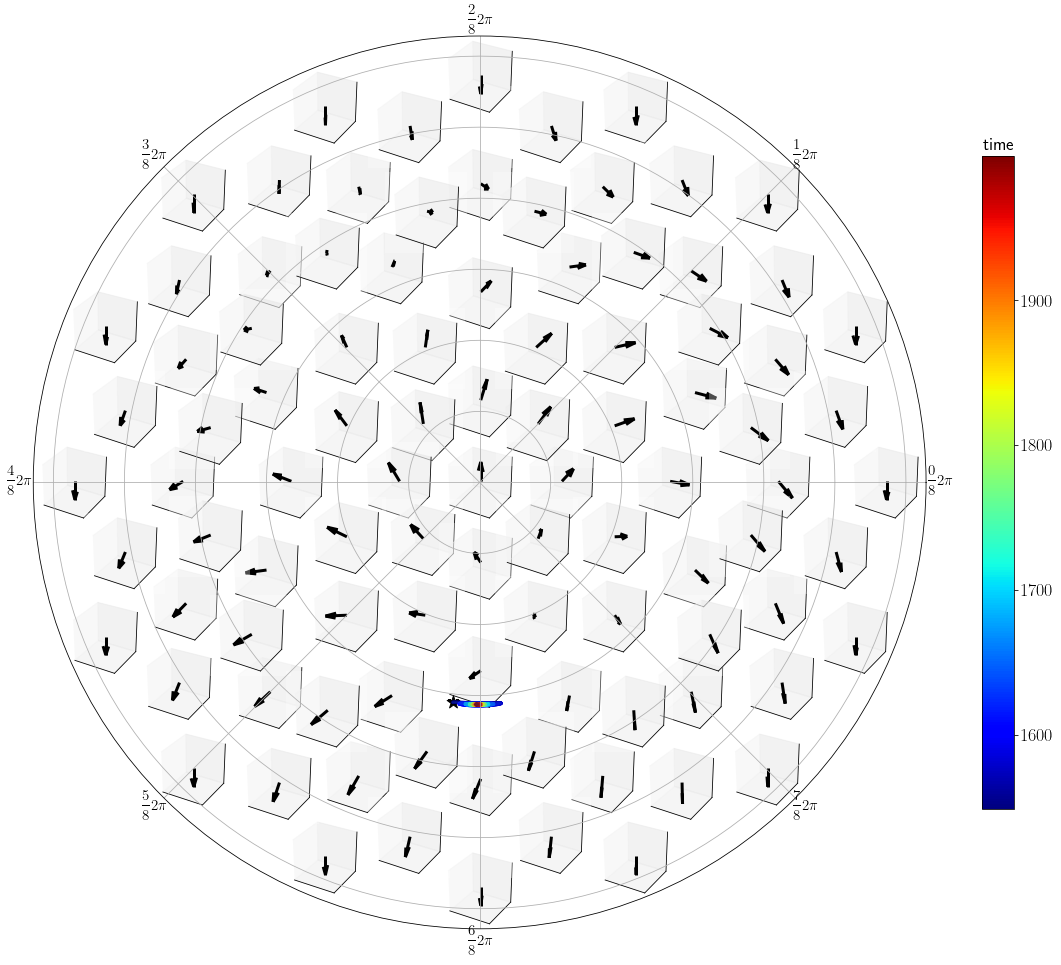

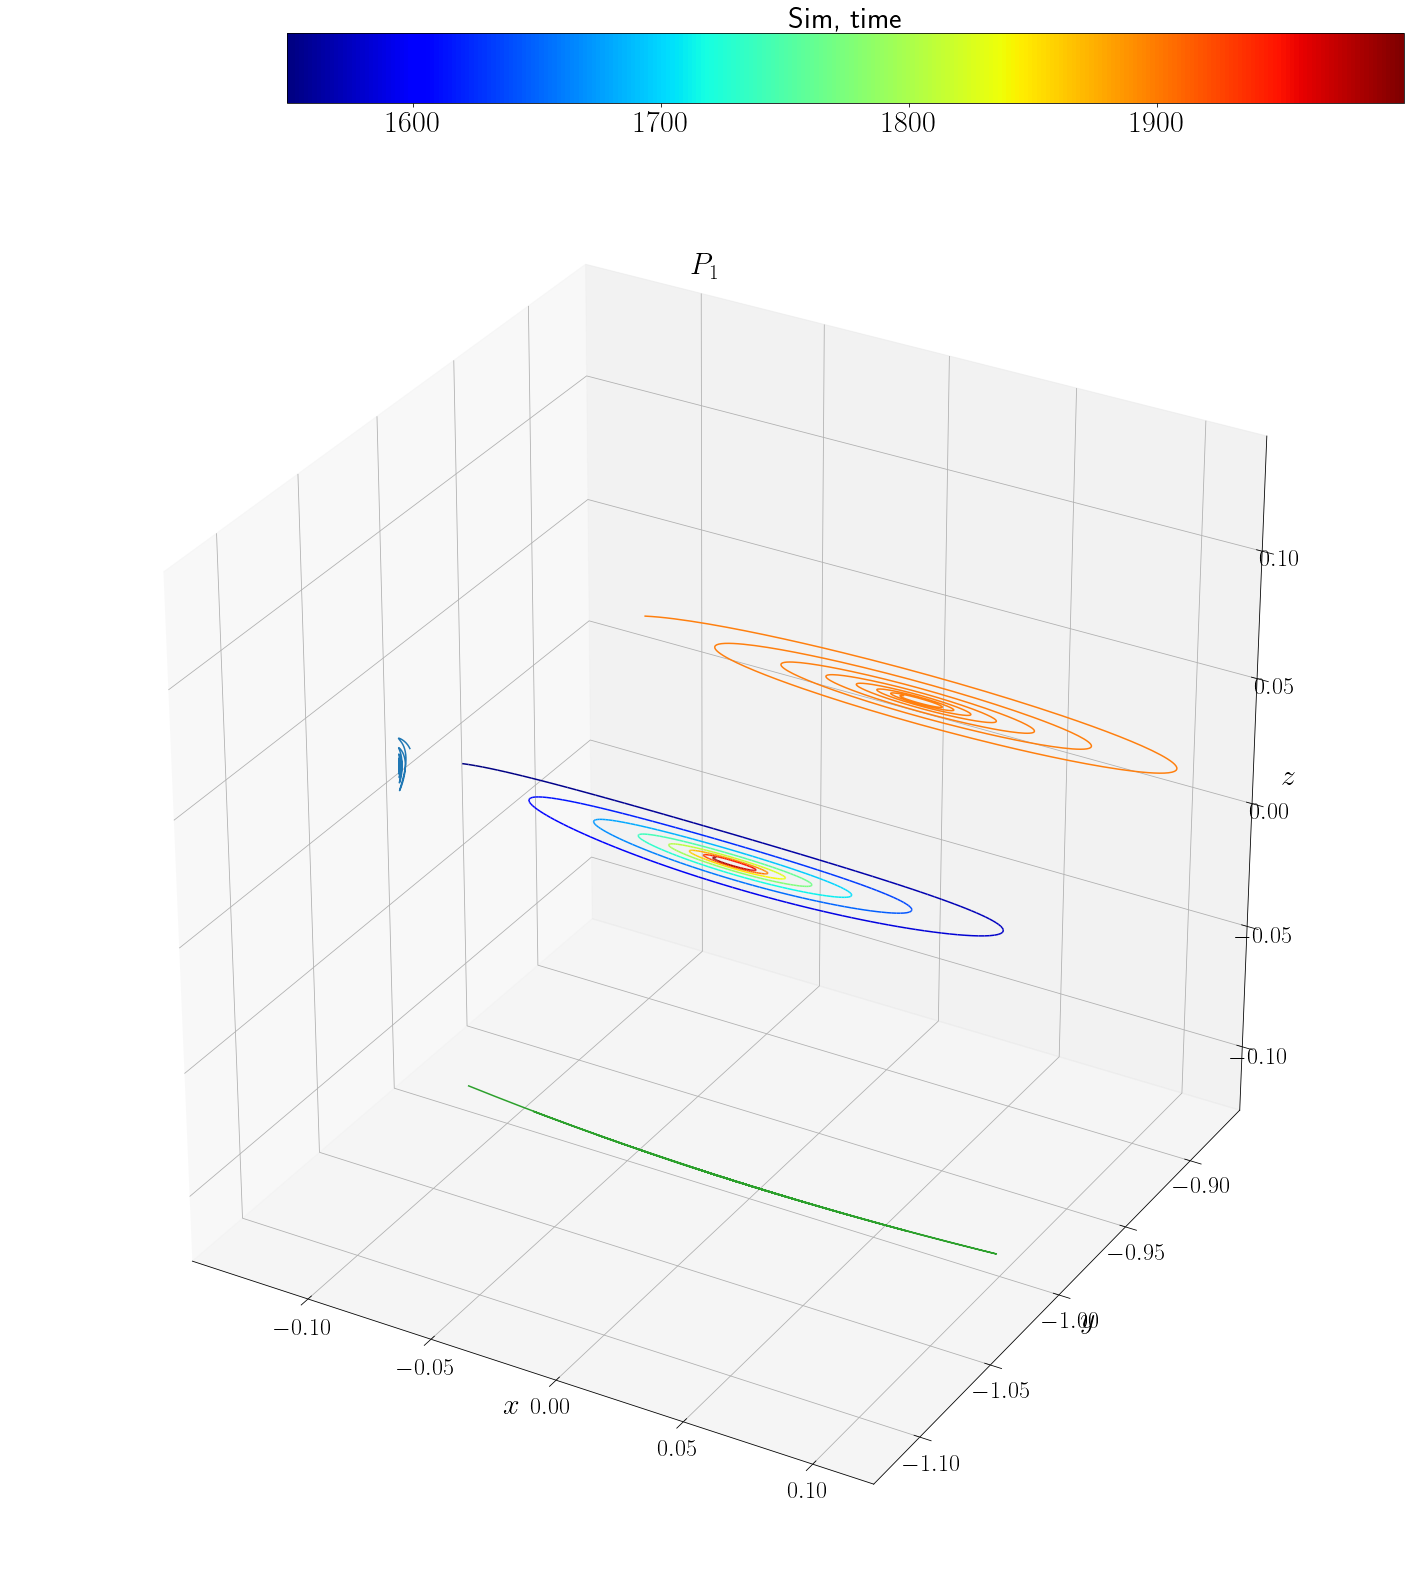

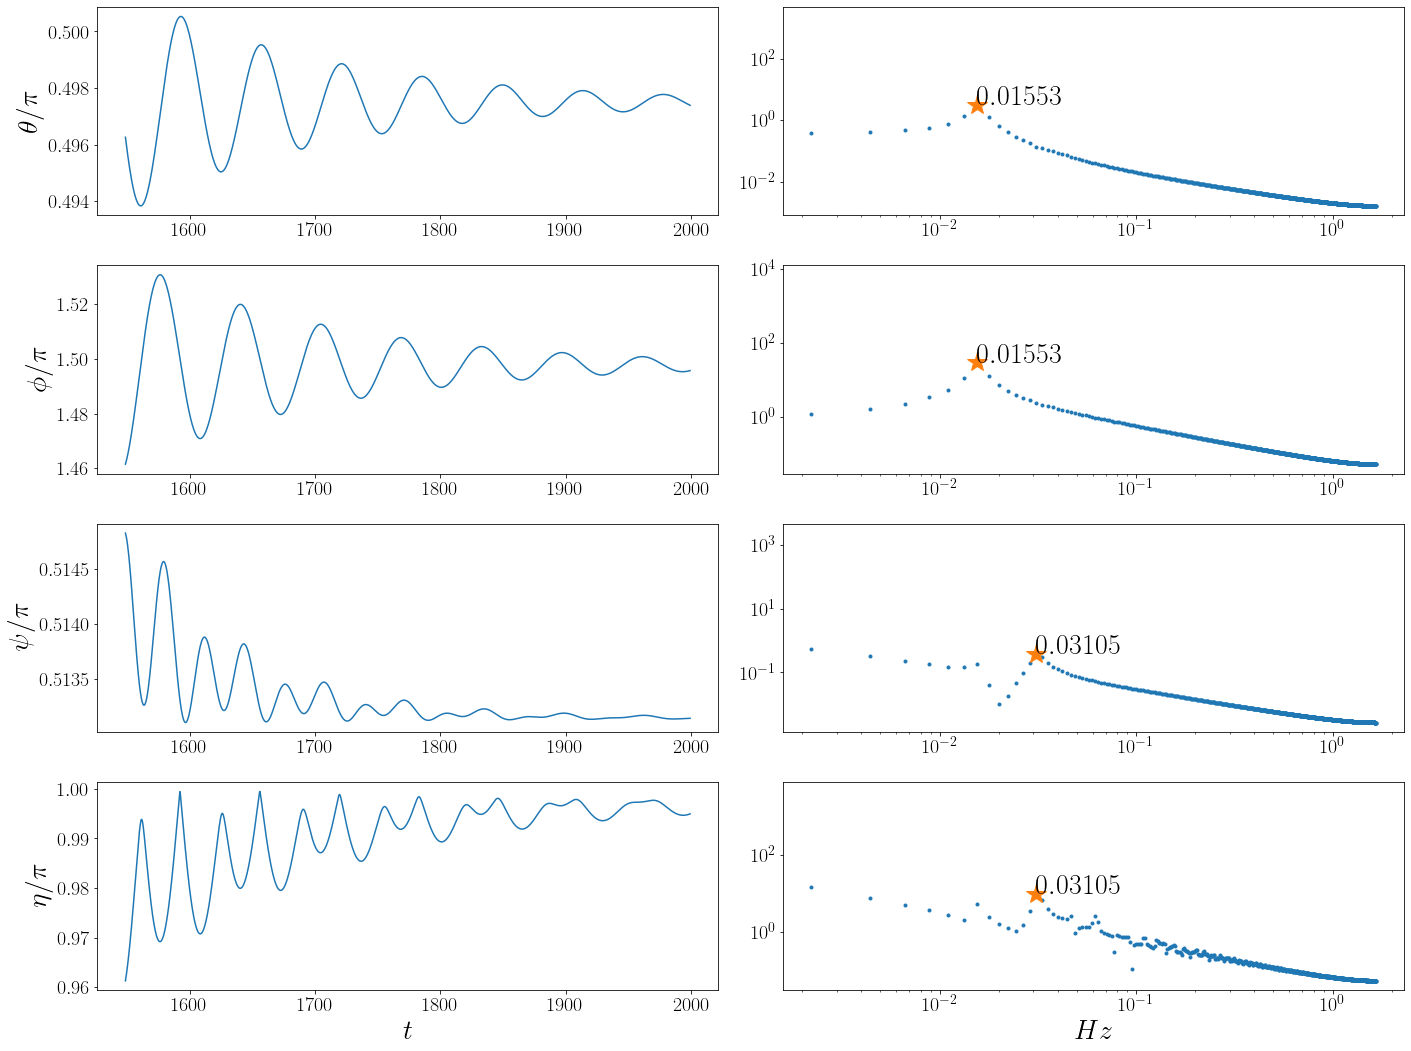

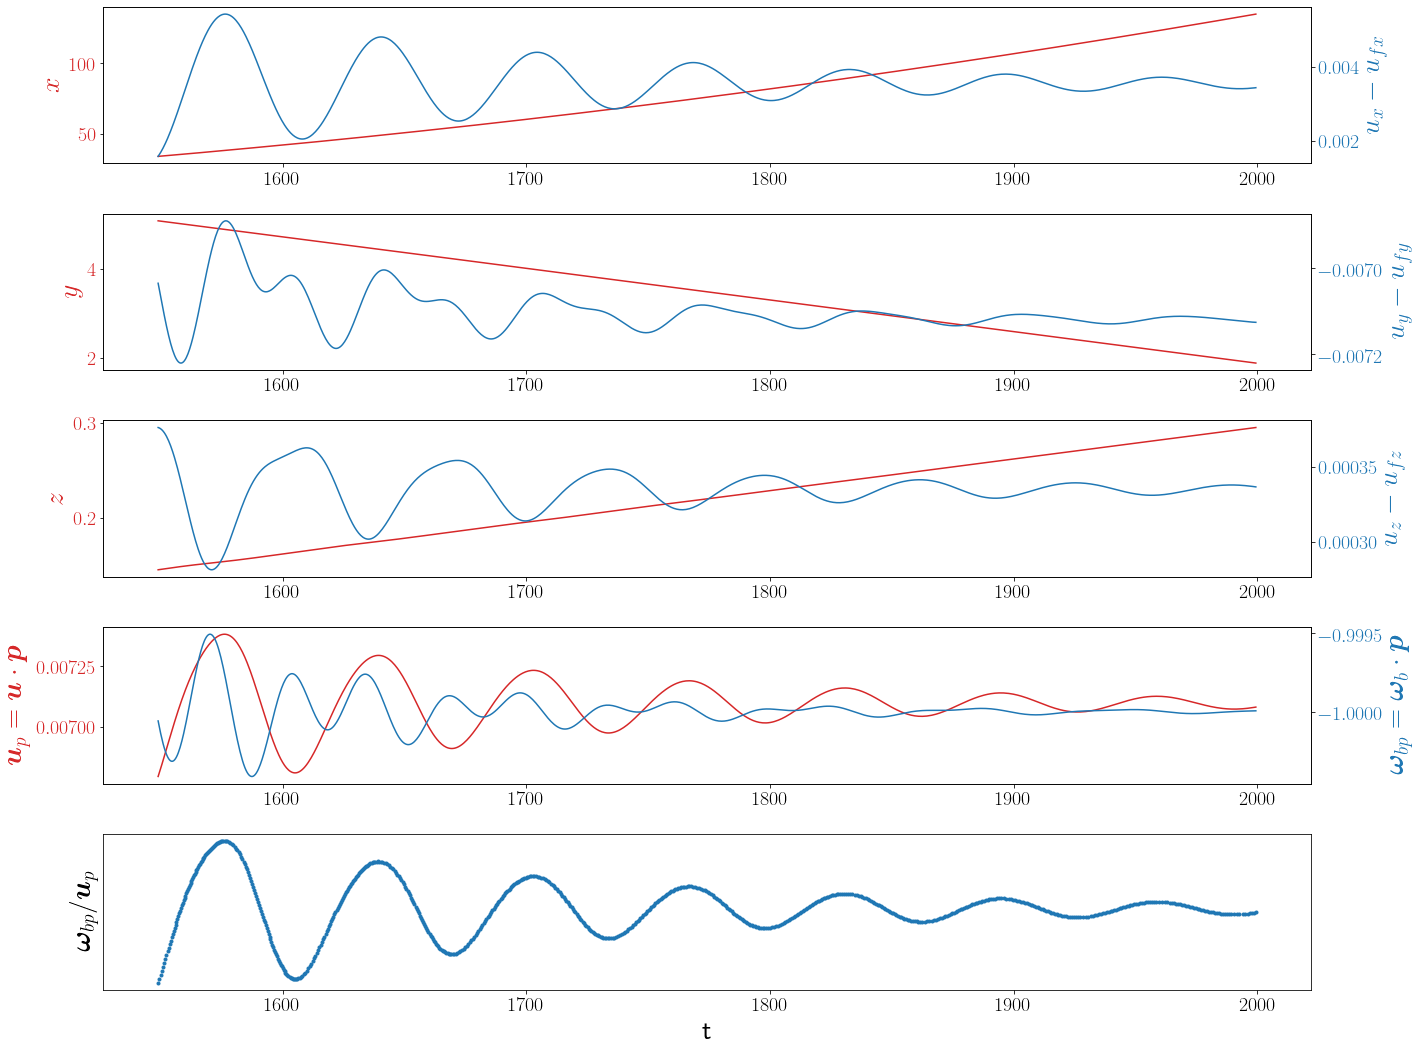

In [6]:
importlib.reload(spf_tb)
theta, phi = 1.503, 1.604

tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
Table_t = tpick['Table_t']
Table_dt = tpick['Table_dt']
Table_X = tpick['Table_X']
Table_P = tpick['Table_P']
Table_P2 = tpick['Table_P2']
Table_theta = tpick['Table_theta']
Table_phi = tpick['Table_phi']
Table_psi = tpick['Table_psi']
Table_eta = tpick['Table_eta']
print('-ini_theta %f -ini_phi %f -ini_psi %f' % 
      (tpick['Table_theta'][0], tpick['Table_phi'][0], tpick['Table_psi'][0]))

freq_pk = spf_tb.get_major_fre(Table_t, Table_theta)
idx = Table_t > Table_t.max() - 1 / freq_pk * 10
# spf_tb.show_table_result(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                          Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], save_every)
spf_tb.show_theta_phi(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                      Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx])
spf_tb.show_theta_phi_psi_eta(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                              Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx])
spf_tb.show_center_X(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                     Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], 
                     table_name=table_name)

In [8]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    display(data.theta_max_fre)

ini_phi       0.000     0.134     0.267     0.401     0.535     0.668  \
ini_theta                                                               
0.000      0.015001  0.015001  0.014999  0.015000  0.015001  0.015000   
0.137      0.014999  0.014999  0.014999  0.015001  0.014999  0.014998   
0.273      0.014999  0.015000  0.014999  0.014999  0.015000  0.015000   
0.410      0.014999  0.014999  0.014999  0.015000  0.015000  0.014999   
0.546      0.014999  0.014999  0.014999  0.014999  0.015001  0.014999   
0.683      0.014999  0.015000  0.014999  0.015001  0.014999  0.015000   
0.820      0.014999  0.014998  0.014999  0.015000  0.015001  0.015000   
0.956      0.015002  0.014999  0.015000  0.014999  0.015001  0.015000   
1.093      0.014999  0.014999  0.015000  0.015002  0.015000  0.015002   
1.229      0.014999  0.014999  0.015000  0.015000  0.015002  0.014999   
1.366      0.015001  0.015000  0.014999  0.014999  0.015001  0.014999   
1.503      0.015001  0.015001  0.015000  0.014998  0.015000  0.014999   
1.639      0.015000  0.015000  0.014999  0.014999  0.014999  0.015000   
1.776      0.014999  0.015000  0.014999  0.014999  0.014999  0.014999   
1.912      0.014999  0.015001  0.014999  0.014998  0.015000  0.015000   
2.049      0.015000  0.015000  0.015000  0.014998  0.014999  0.014999   
2.185      0.014999  0.015000  0.014999  0.014998  0.014999  0.014999   
2.322      0.014999  0.014999  0.014998  0.014999  0.014999  0.014999   
2.459      0.015000  0.014999  0.014999  0.014999  0.015000  0.015002   
2.595      0.014999  0.015001  0.015001  0.015000  0.015001  0.014999   
2.732      0.015001  0.014999  0.015001  0.015000  0.014999  0.014999   
2.868      0.014999  0.014999  0.015001  0.014999  0.014999  0.015000   
3.005      0.014999  0.014999  0.014999  0.015001  0.014999  0.014999   
3.142      0.014999  0.014999  0.014999  0.015002  0.014998  0.014999   

ini_phi       0.802     0.936     1.069     1.203     1.337     1.471  \
ini_theta                                                               
0.000      0.015001  0.015001  0.015002  0.014999  0.015001  0.014999   
0.137      0.014999  0.014999  0.015000  0.014999  0.014999  0.014999   
0.273      0.014999  0.014999  0.015000  0.014999  0.014999  0.014999   
0.410      0.015000  0.014999  0.014999  0.014999  0.015002  0.015001   
0.546      0.015001  0.014999  0.015000  0.014999  0.014998  0.014999   
0.683      0.014999  0.014999  0.015000  0.015000  0.014999  0.015000   
0.820      0.014999  0.014999  0.015002  0.014998  0.019000  0.015002   
0.956      0.014999  0.015000  0.014999  0.014999  0.015000  0.014999   
1.093      0.014999  0.014999  0.014999  0.014999  0.015000  0.018999   
1.229      0.014999  0.015001  0.014999  0.014999  0.015000  0.014999   
1.366      0.015000  0.015001  0.014998  0.014999  0.014999  0.015002   
1.503      0.014999  0.014999  0.015000  0.015000  0.015000  0.015001   
1.639      0.014999  0.015000  0.015002  0.014999  0.015001  0.015000   
1.776      0.014999  0.014999  0.014999  0.014999  0.014998  0.015000   
1.912      0.014999  0.014999  0.014998  0.014999  0.014999  0.015000   
2.049      0.014998  0.015001  0.014999  0.015000  0.015001  0.014999   
2.185      0.015001  0.015000  0.014998  0.018999  0.014999  0.014998   
2.322      0.014999  0.015001  0.018999  0.015001  0.014999  0.015000   
2.459      0.015001  0.014999  0.015000  0.014999  0.014998  0.014999   
2.595      0.014999  0.015000  0.015000  0.014999  0.014999  0.015000   
2.732      0.015001  0.014999  0.014999  0.014998  0.015001  0.018999   
2.868      0.015001  0.014999  0.015000  0.014999  0.015001  0.014999   
3.005      0.014999  0.015000  0.014999  0.015000  0.014999  0.015000   
3.142      0.015001  0.014999  0.014999  0.015001  0.014999  0.015000   

ini_phi       1.604     1.738     1.872     2.005     2.139     2.273  \
ini_theta                                                               
0.000      0.014999  0.015000  0.015000  0.015000  0.014

In [9]:
# sort all frequrents
with np.printoptions(precision=10, suppress=True, threshold=1e10):
    print(np.flipud(np.sort(data.theta_max_fre.values.flatten())))

[0.0190018365 0.0190011511 0.0190008563 0.0190006989 0.0190004761 0.0190004369
 0.0190003666 0.0190003248 0.0190002817 0.0190001518 0.019000005  0.0190000013
 0.0189999675 0.0189999537 0.018999952  0.0189999264 0.0189998621 0.0189998402
 0.0189998252 0.0189997596 0.0189997387 0.0189996271 0.0189996185 0.0189995827
 0.0189995491 0.0189995397 0.018999538  0.0189995078 0.018999499  0.0189994926
 0.0189994501 0.0189994137 0.0189993979 0.0189993797 0.0189993626 0.01899932
 0.0189993047 0.0189992755 0.0189992462 0.0189992408 0.0189992077 0.0189992003
 0.0189991861 0.0189991769 0.0189991765 0.0189990661 0.0189990598 0.0189990481
 0.0189990236 0.0189990206 0.0189990095 0.0189990016 0.0189989859 0.0189989752
 0.0189989569 0.0189988515 0.0189988373 0.0189988215 0.0189987355 0.0150027727
 0.0150024285 0.0150023942 0.0150022883 0.0150022072 0.0150021394 0.0150020195
 0.015002015  0.0150019996 0.015001988  0.0150019364 0.015001919  0.0150018825
 0.015001854  0.0150018335 0.0150018071 0.0150018017 0

True

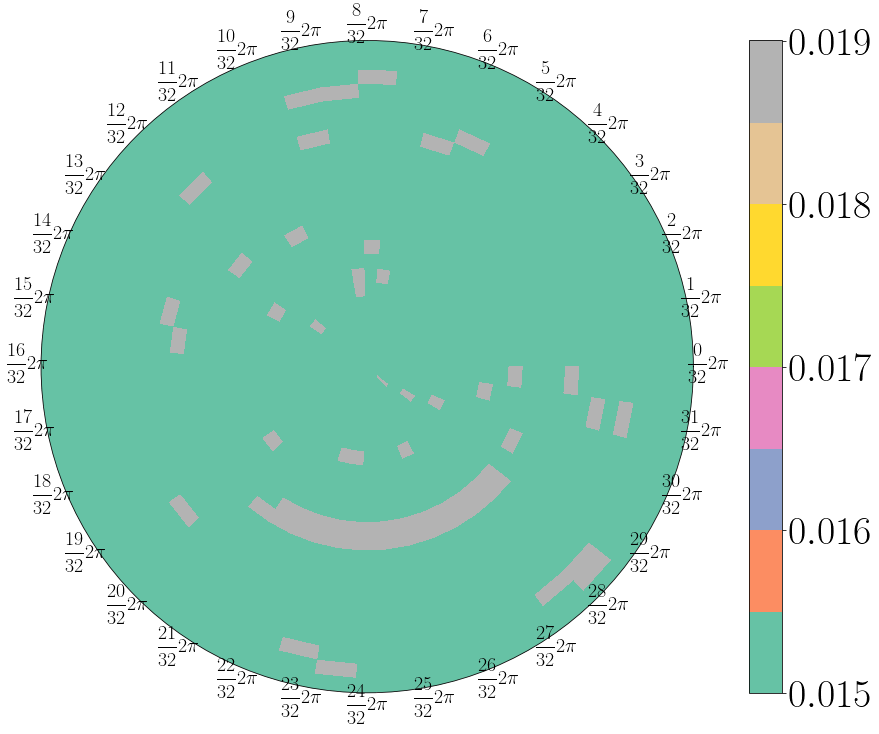

In [10]:
spf_tb.show_traj_phase_map_fre(theta_max_fre)
# spf_tb.show_traj_phase_map_fre(phi_max_fre)
# spf_tb.show_traj_phase_map_fre(psi_max_fre)
# spf_tb.show_traj_phase_map_fre(eta_max_fre)

0.0 0.0
-ini_theta 0.000000 -ini_phi 0.000000 -ini_psi 0.000000


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:609: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


0.137 5.481
-ini_theta 0.136591 -ini_phi 5.481077 -ini_psi 0.000000


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:609: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


frequency in the range (0.014800, 0.015200)
make folder ecoC01B05_T0.5_psi-0b/fre_separate/fre_0.015000



frequency in the range (0.018800, 0.019200)
make folder ecoC01B05_T0.5_psi-0b/fre_separate/fre_0.019000


True

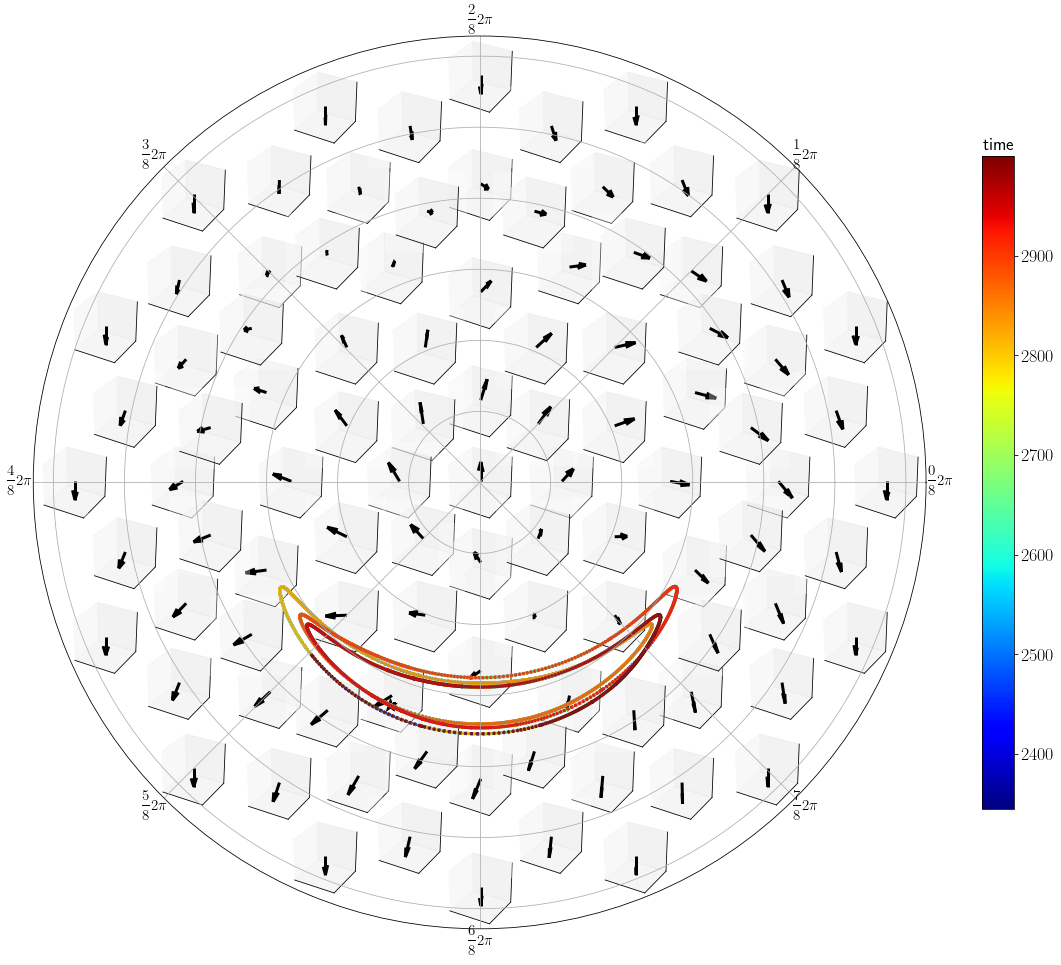

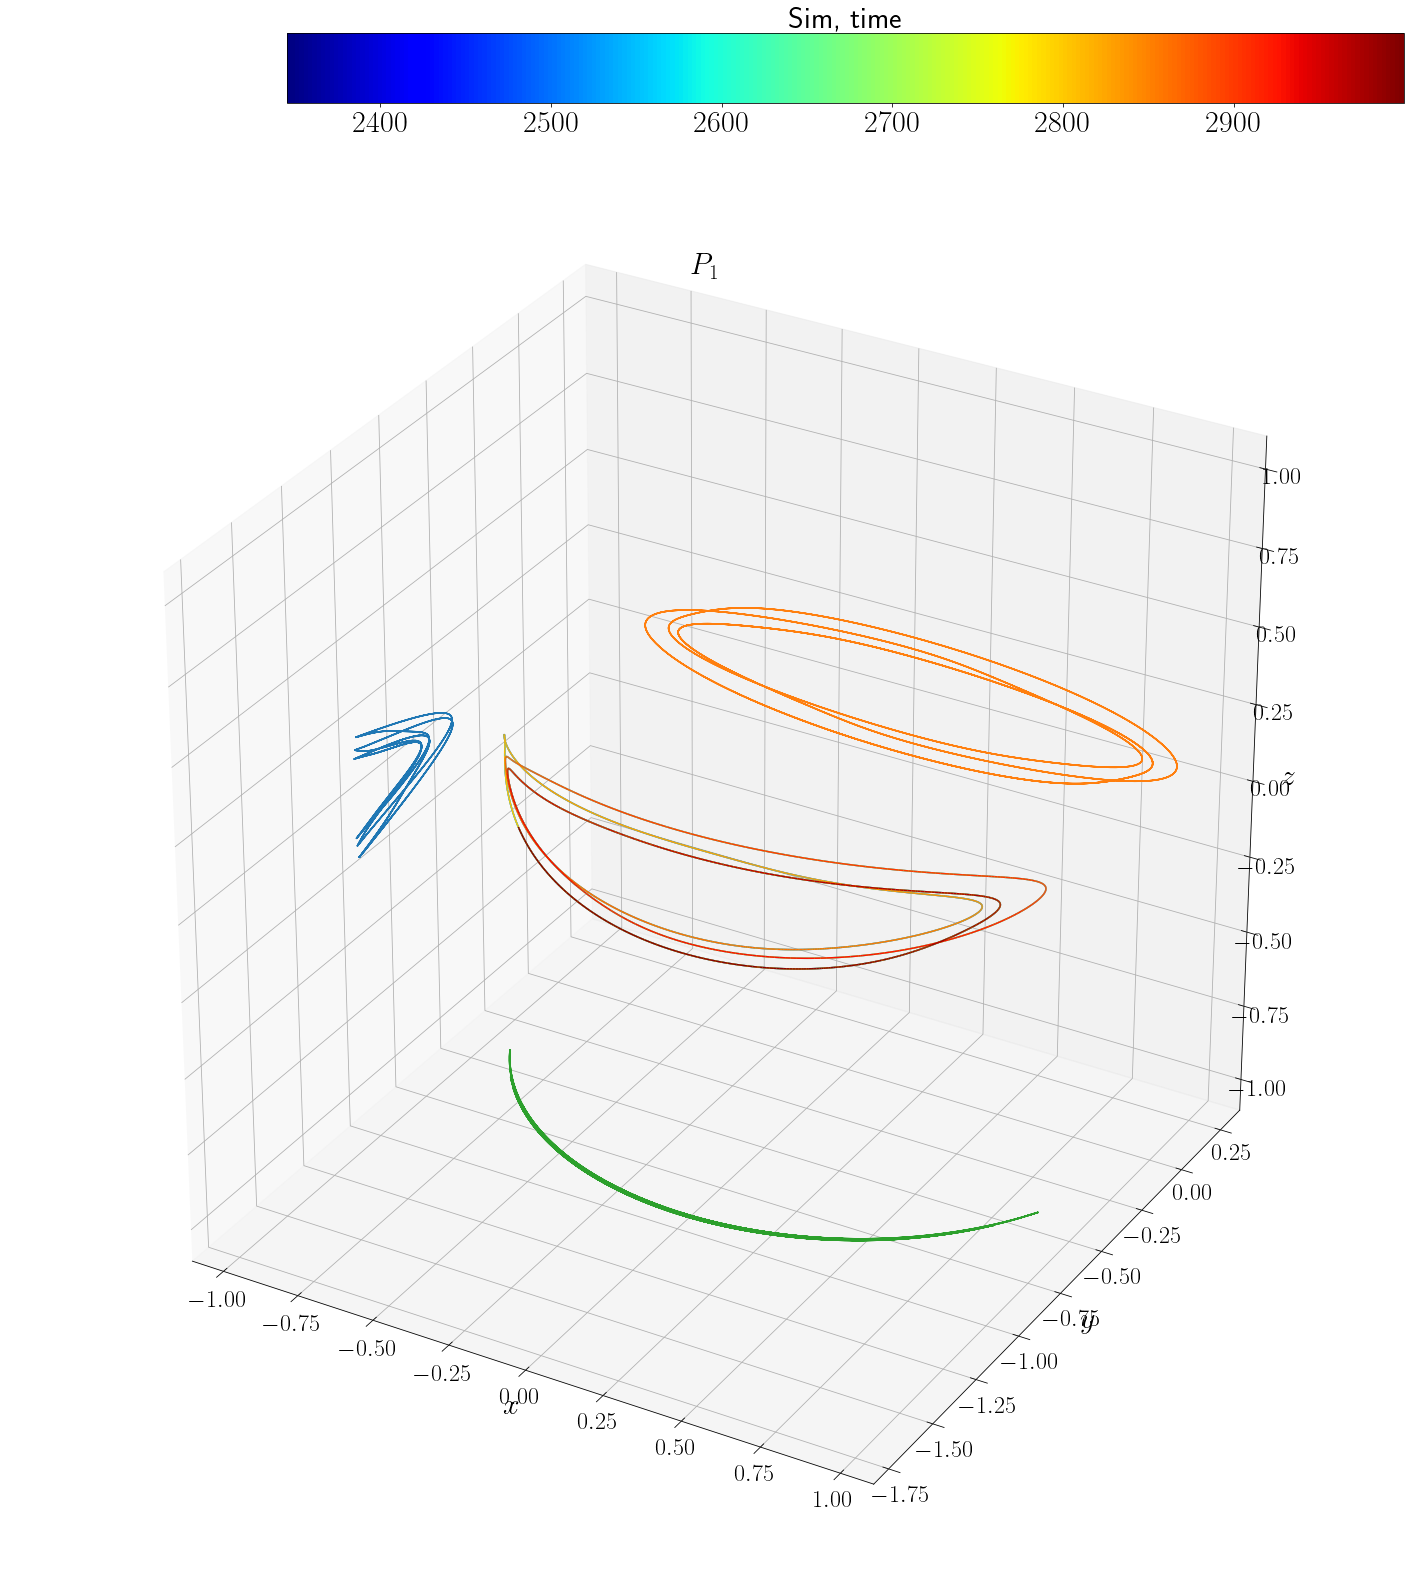

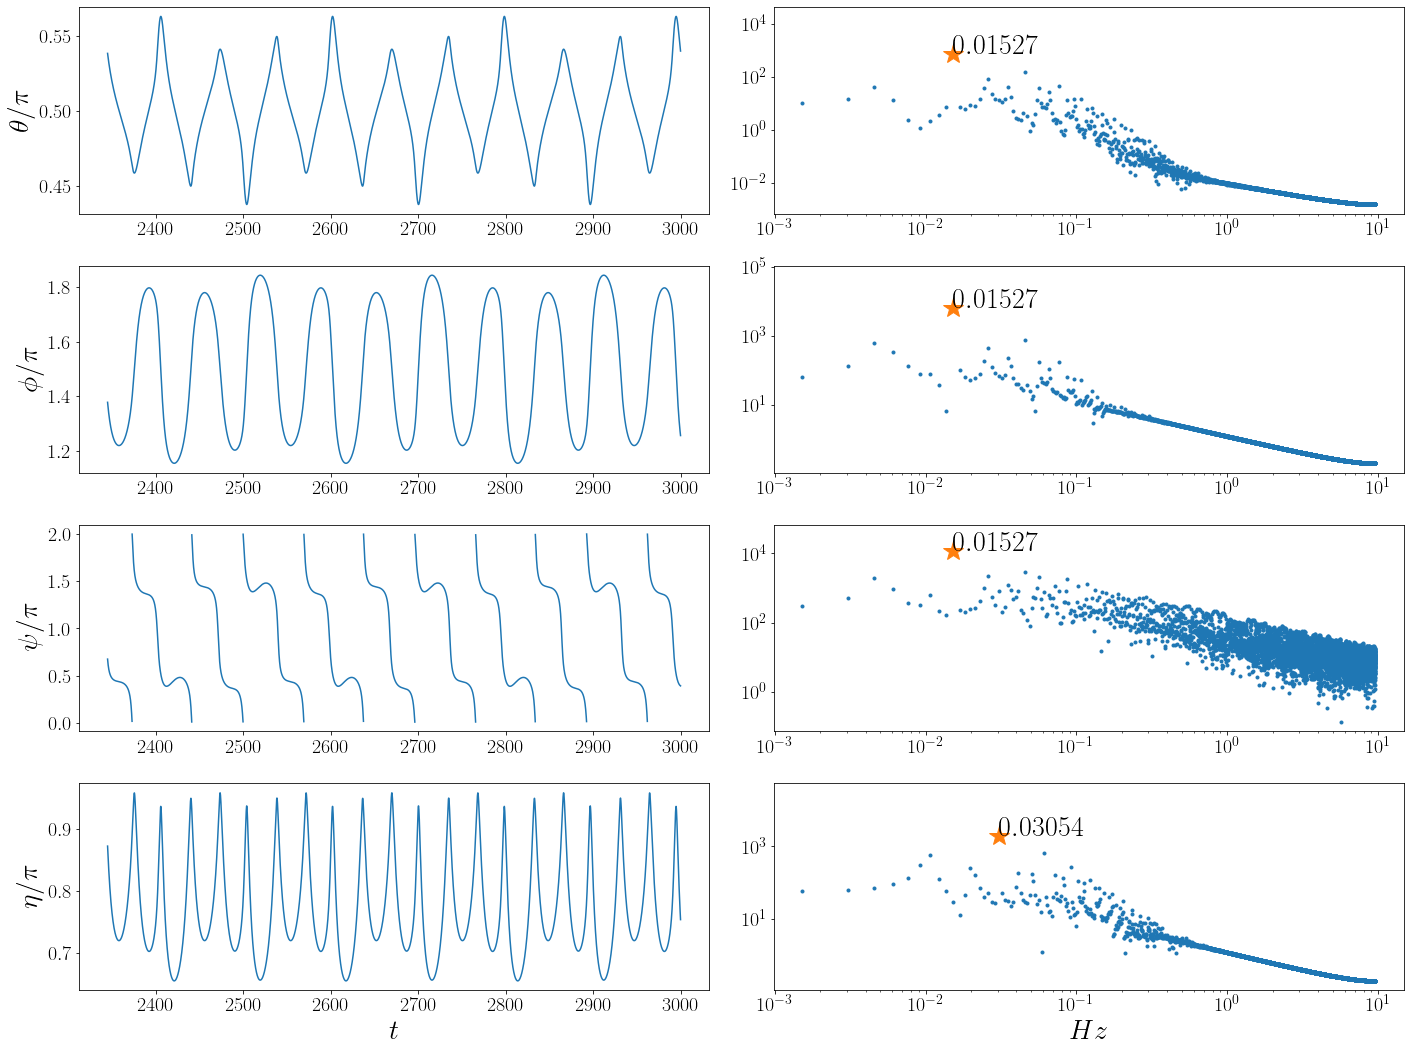

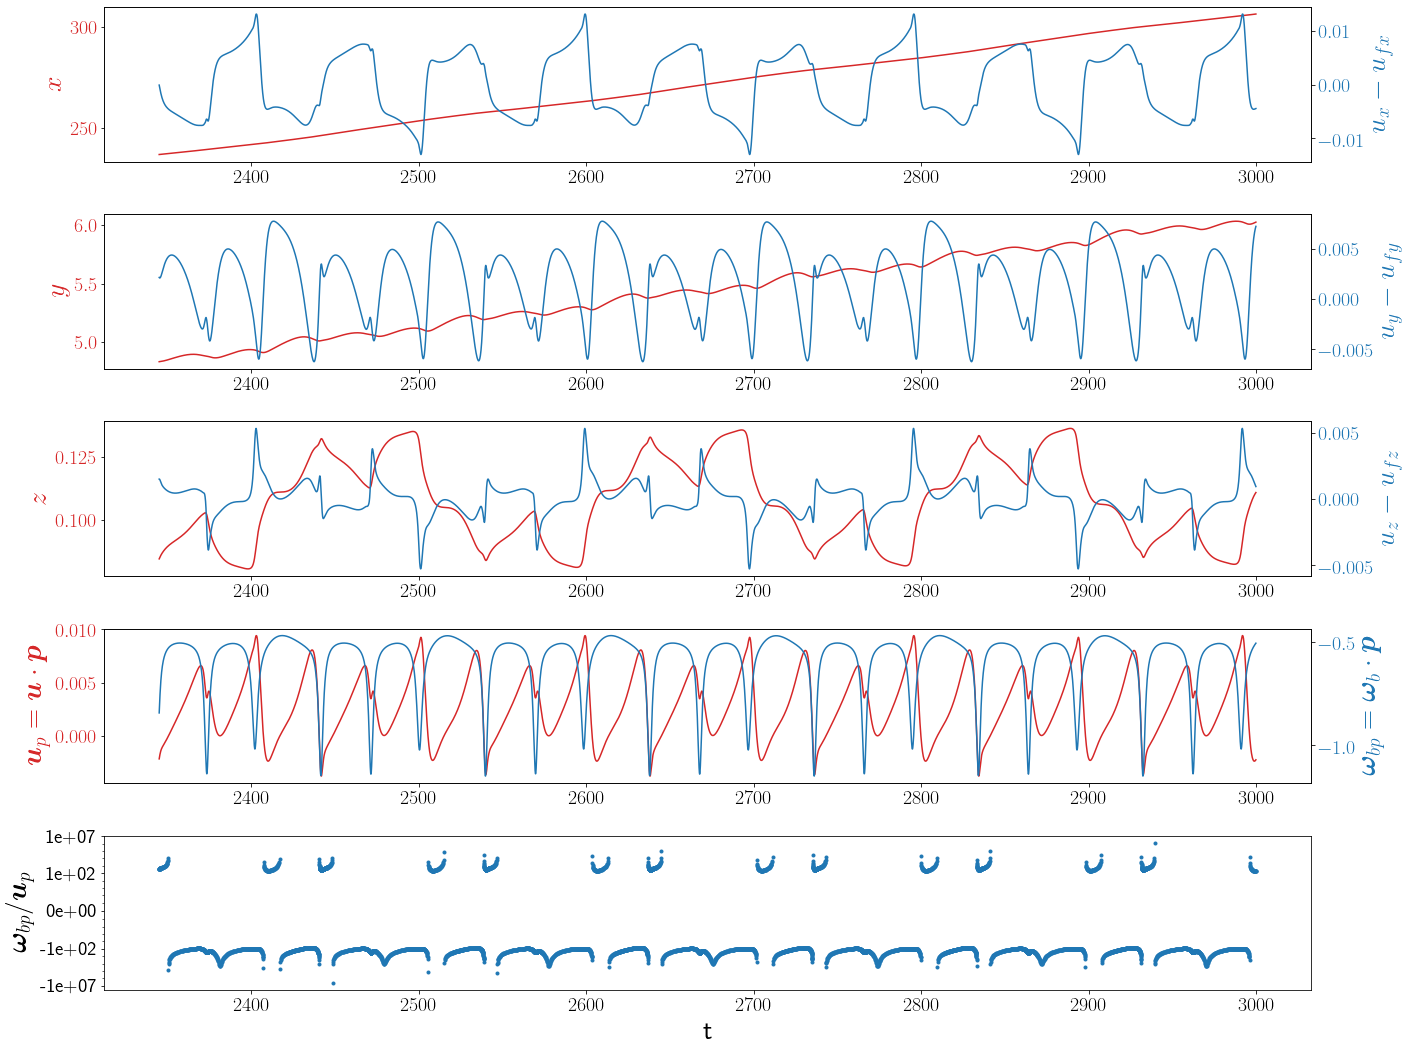

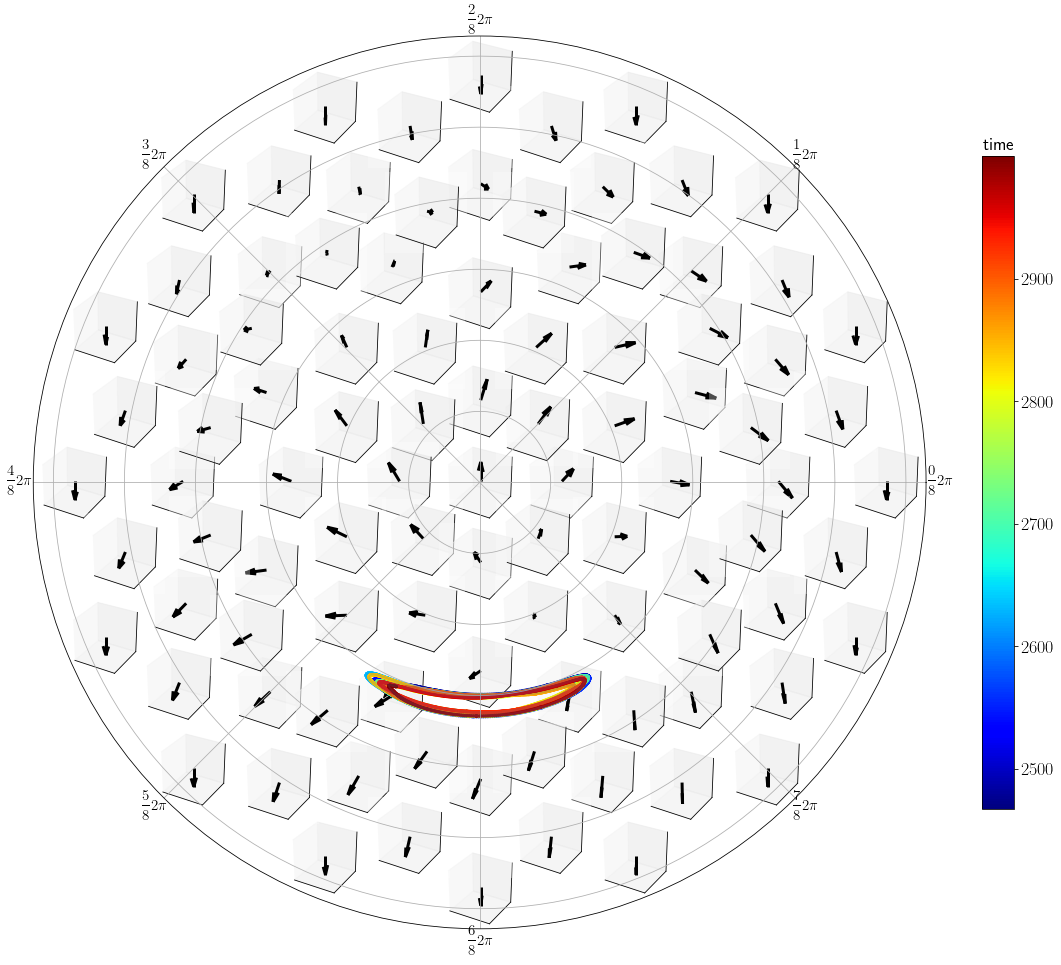

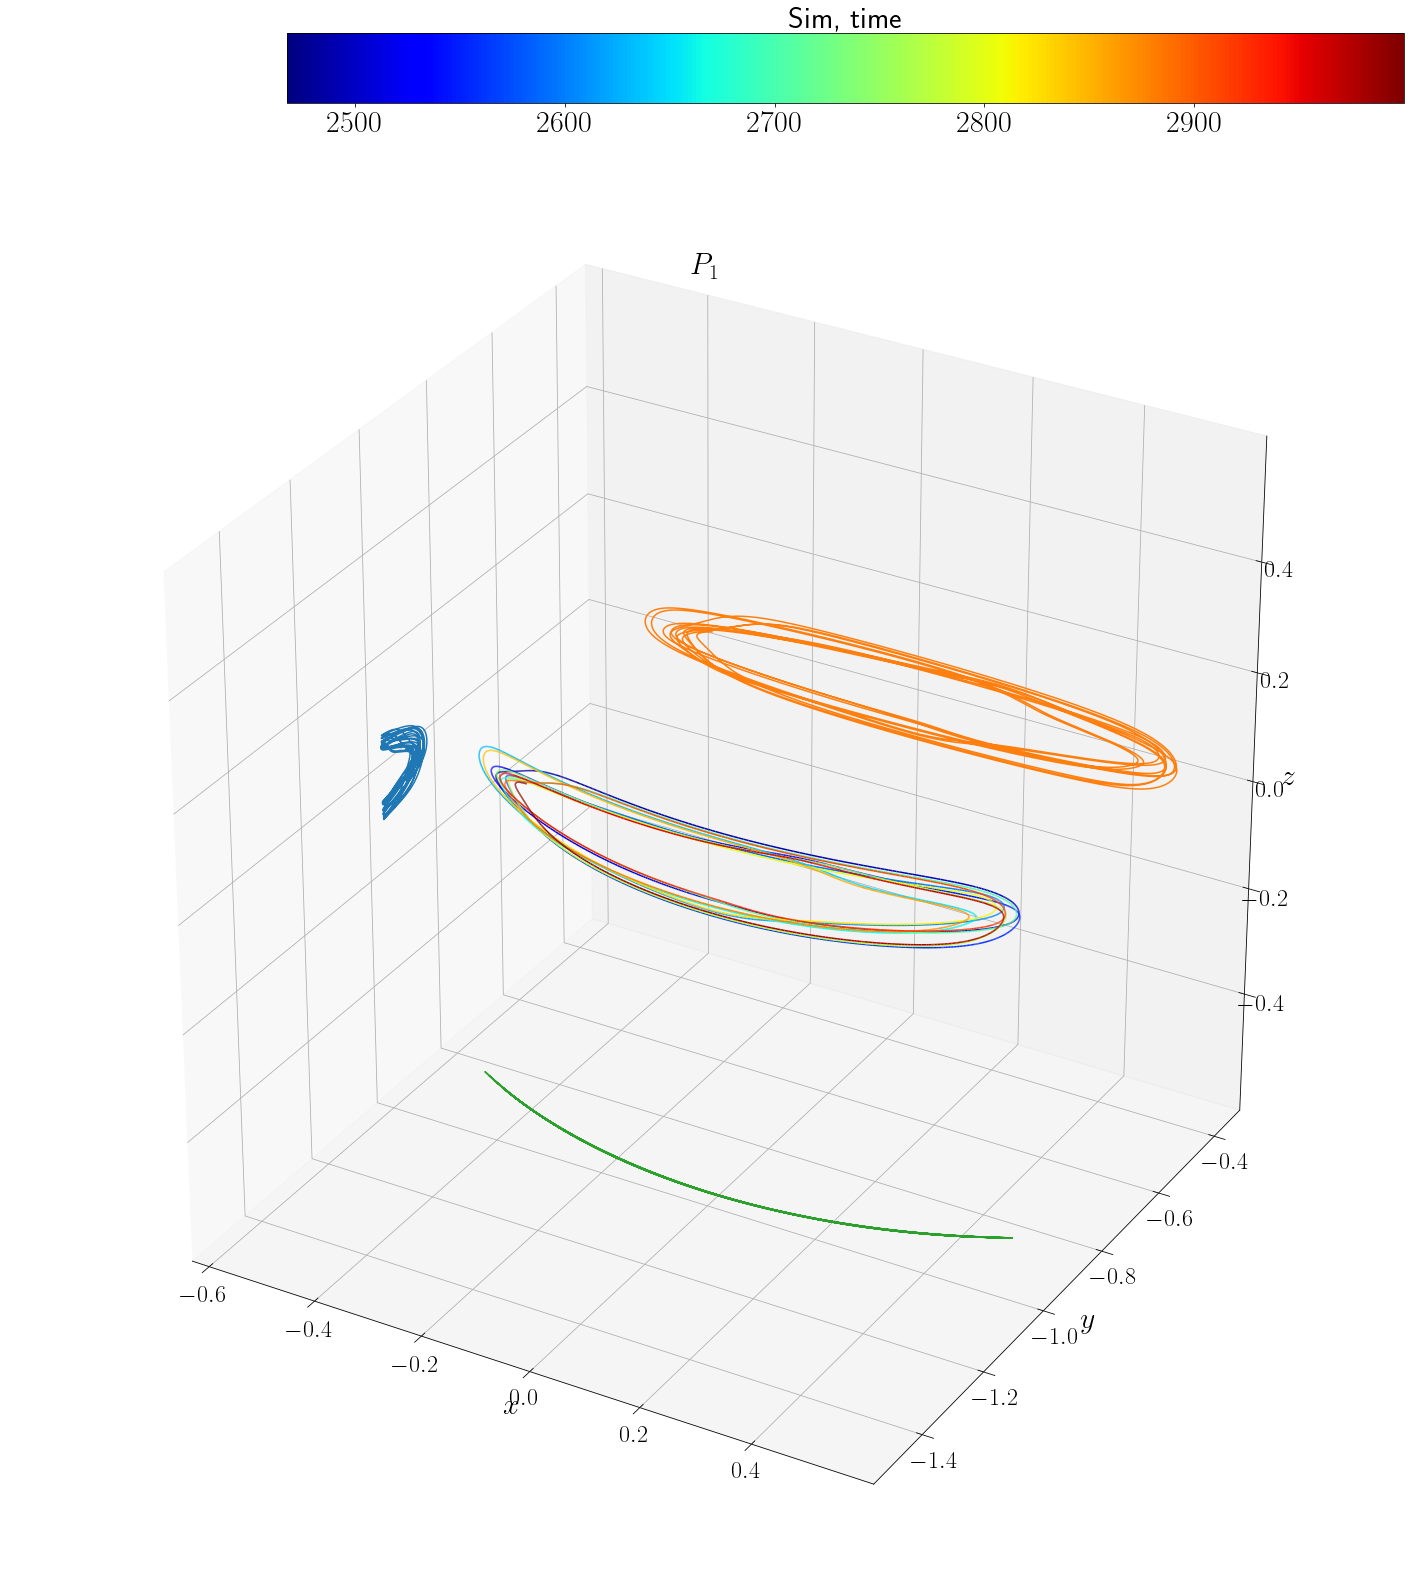

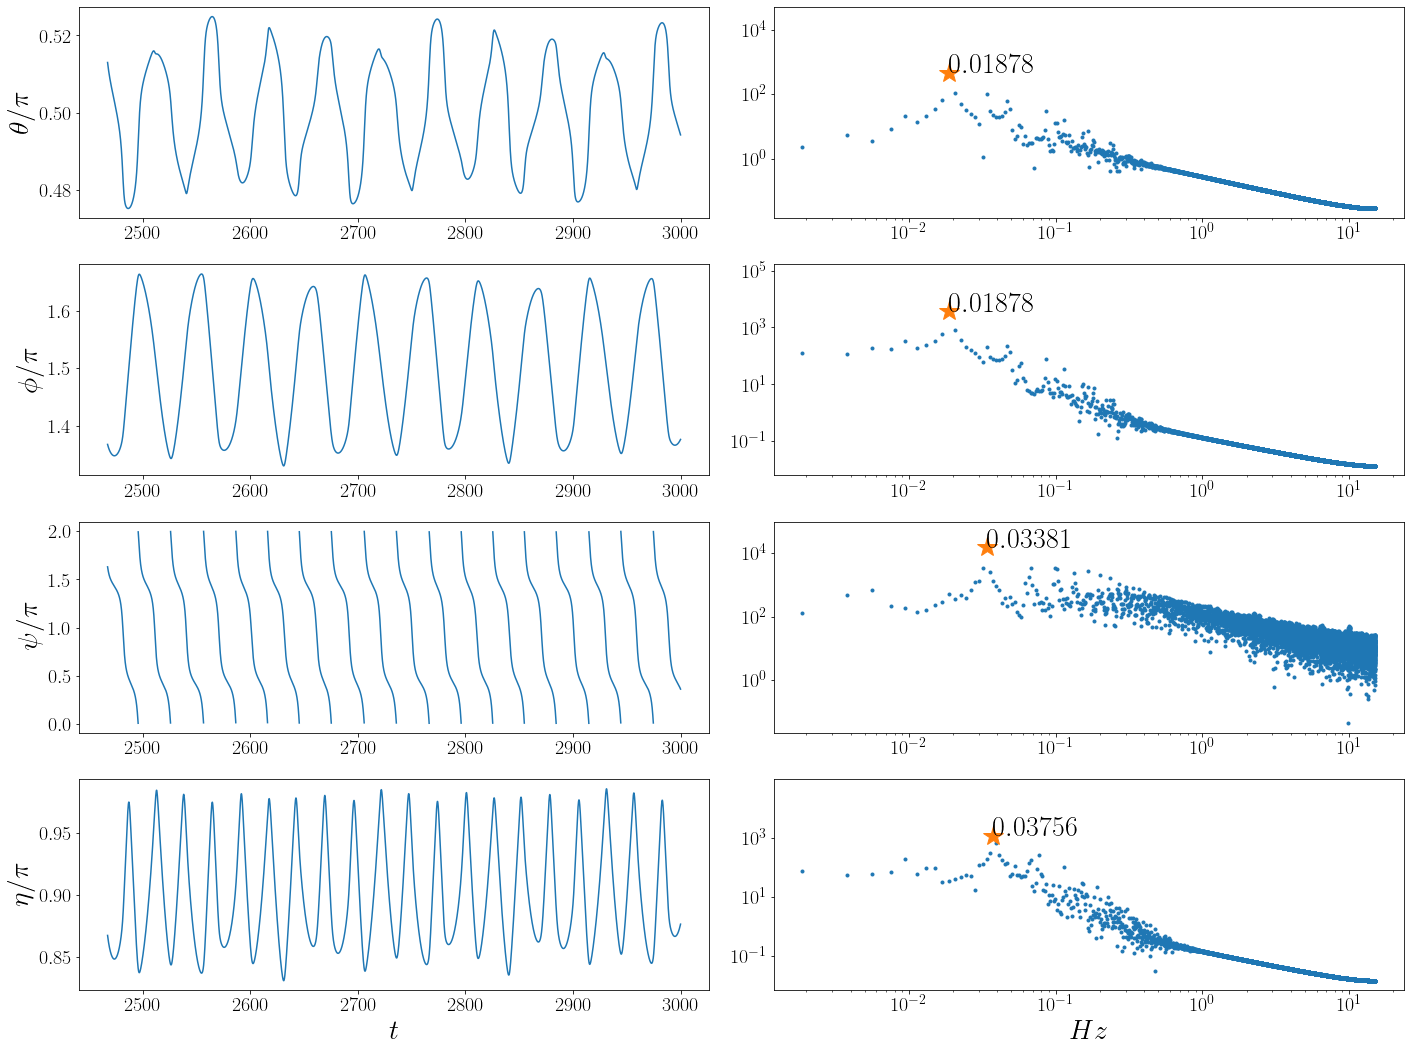

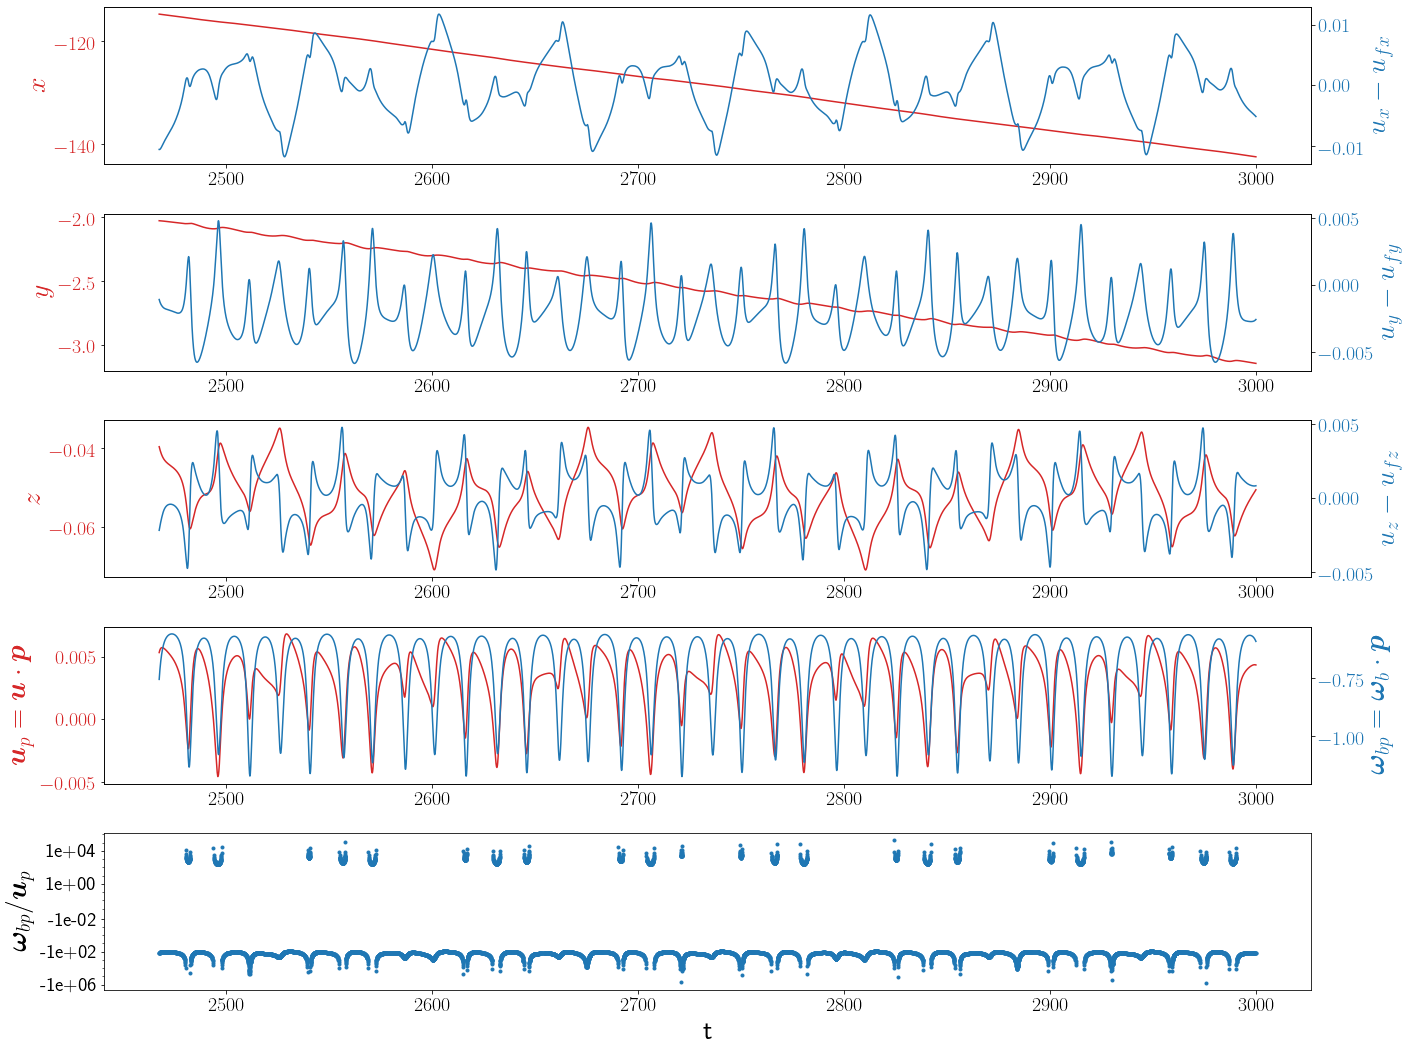

In [11]:
# put images with same frequence into a subdirect
importlib.reload(spf_tb)
def t_show_idx(iidx):
    theta = type_fre.index.values[iidx[0][0]]
    phi = type_fre.columns.values[iidx[1][0]]
    print(theta, phi)
    spf_tb.show_pickle_results(job_dir, theta, phi, table_name)
    return True

tfre = theta_max_fre.copy()
check_fre_list = [0.0150, 0.0190]
atol_fre_list =  [0.0002, 0.0002]

type_fre = tfre.copy()
type_fre.iloc[:, :] = len(check_fre_list) 
for i0, (check_fre, atol_fre) in enumerate(zip(check_fre_list, atol_fre_list)):
    use_idx = np.isclose(tfre, check_fre, rtol=0, atol=atol_fre)
    type_fre.iloc[use_idx] = i0
    iidx = np.where(use_idx)
    t_show_idx(iidx)

# plot one of the remaind cases
if np.any(type_fre.values == len(check_fre_list)):
    iidx = np.where(type_fre.values == len(check_fre_list))
    t_show_idx(iidx)

spf_tb.show_traj_phase_map_type(type_fre)
spf_tb.save_separate_angleList_fft(job_dir, tfre, check_fre_list, atol_fre_list)

In [ ]:
# create phase map
importlib.reload(spf_tb)
def tget_ax0():
    n_xticks = 32
    xticks = np.arange(n_xticks)
    fig = plt.figure(figsize=(20, 20))
    fig.patch.set_facecolor('white')
    axs = []
    axs.append(fig.add_subplot(221, polar=True))
    axs.append(fig.add_subplot(222, polar=True))
    axs.append(fig.add_subplot(223, polar=True))
    axs.append(fig.add_subplot(224, polar=True))
    for ax0 in axs:
        ax0.set_xticks(xticks / n_xticks * 2 * np.pi)
        ax0.set_xticklabels(['$\dfrac{%d}{%d}2\pi$' % (i0, n_xticks) for i0 in xticks])
        ax0.set_yticklabels([])
        ax0.set_ylim(0, np.pi)
    plt.tight_layout()
    return fig, axs

check_fre_list = [1.000, 0.0220, 1.0000, 0.0540]
atol_list =      [0.004, 0.0005, 0.0005, 0.0005]
color_list =     ['b',   'g',    'r',    'c',   'm', 'y', 'k']
psi_lim_fct = 20
resampling_fct = 10

data0['use_max_fre'] = data0.theta_max_fre
case_path_list = spf_tb.separate_fre_path(check_fre_list, atol_list, data0, pickle_path_list)
for idx, psi_lim1 in enumerate(np.linspace(0, 2 * np.pi, psi_lim_fct * 16, 
                                           endpoint=False)[::psi_lim_fct]):
    fig, (ax0, ax1, ax2, ax3) = tget_ax0()
    ax_list = [ax0, ax0, ax1, ax2, ax3]
    psi_lim = (psi_lim1, psi_lim1 + 2 * np.pi / (psi_lim_fct * 16))
    desc = '$\psi\in[%.3f\pi, %.3f\pi)$' % ((psi_lim[0] / np.pi), (psi_lim[1] / np.pi))
    fig.suptitle(desc, fontsize=fontsize*0.8)
    for check_fre, case_path, color, axi in zip(check_fre_list, case_path_list, color_list, ax_list):
        thandle = '%f' % check_fre
        spf_tb.draw_phase_map_theta(case_path, color, psi_lim, axs=(axi, ax_list[-1]), thandle=thandle, 
                                    resampling=True, resampling_fct=resampling_fct)
    tdir = os.path.join(PWD, job_dir, 'phase_mape_fre')
    if not os.path.exists(tdir):
        os.makedirs(tdir)
    figname = os.path.join(tdir, '%04d.png' % (idx))
    fig.savefig(os.path.join(tdir, figname))
    print('save to %s' % figname)
    plt.close(fig)


/home/zhangji/stokes_flow_master/codeStore/support_fun_table.py:12: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


0th frequence range: (0.996000, 1.004000)
1th frequence range: (0.021500, 0.022500)
2th frequence range: (0.999500, 1.000500)
3th frequence range: (0.053500, 0.054500)
tmax_fre=0.048002, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th1.639_ph0.401_ps0.000_D20190714_T225427.pickle
tmax_fre=0.052003, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th0.683_ph2.941_ps0.000_D20190715_T023809.pickle
tmax_fre=0.035997, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th1.639_ph1.738_ps0.000_D20190715_T020546.pickle
tmax_fre=0.052011, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th1.366_ph3.075_ps0.000_D20190715_T024550.pickle
tmax_fre=0.051998, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th1.229_ph3.208_ps0.000_D20190715_T025014.pickle
tmax_fre=0.036003, n_match=0 /home/zhangji/stok

tmax_fre=0.036997, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th1.503_ph5.347_ps0.000_D20190715_T042036.pickle
tmax_fre=0.049998, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th0.820_ph6.016_ps0.000_D20190715_T045020.pickle
tmax_fre=0.051997, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th2.868_ph3.208_ps0.000_D20190715_T025013.pickle
tmax_fre=0.036998, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th1.503_ph4.278_ps0.000_D20190715_T033910.pickle
tmax_fre=0.045999, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th3.142_ph3.476_ps0.000_D20190715_T031731.pickle
tmax_fre=0.053009, n_match=0 /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/th3.142_ph0.267_ps0.000_D20190714_T225427.pickle
tmax_fre=0.051996, n_match=0 /home/zhangji/stokes_flow_mas


save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/phase_mape_fre/0000.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/phase_mape_fre/0001.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/hlxC01_a_psi-0e/phase_mape_fre/0002.png


# calculate the phase map of stable trajectory using the KMeans method. 

In [186]:
# show phase map of theta-phi, part 1
importlib.reload(spf_tb)
job_dir = 'ecoC01B05_T0.01_psi-0a'
table_name = 'ecoC01B05_T0.01'

t_headle = '(.*?).pickle'
t_path = os.listdir(os.path.join(PWD, job_dir))
filename_list = [filename for filename in os.listdir(os.path.join(PWD, job_dir)) 
                 if re.match(t_headle, filename) is not None]
ini_theta_list = []
ini_phi_list = []
lst_eta_list = []
pickle_path_list = []
idx_list = []
theta_primary_fre_list = []
phi_primary_fre_list = []
psi_primary_fre_list = []
for i0, tname in enumerate(tqdm_notebook(filename_list[:])):
    tpath = os.path.join(PWD, job_dir, tname)
    with open(tpath, 'rb') as handle:
        tpick = pickle.load(handle)
    ini_theta_list.append(tpick['ini_theta'])
    ini_phi_list.append(tpick['ini_phi'])
    lst_eta_list.append(tpick['Table_eta'][-1])
    pickle_path_list.append(tpath)
    idx_list.append(i0)
    
    # fft rule
    tx = tpick['Table_t']
    tmin = np.max((0, tx.max() - 1000))
    idx = tx > tmin
    # the last frequence is the major frequence. 
    use_fft_number = 3
    t1 = -use_fft_number - 1
    theta_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_theta'][idx])[t1:-1])
    phi_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_phi'][idx])[t1:-1])
    psi_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_psi'][idx])[t1:-1])

/home/zhangji/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [216]:
# show phase map of theta-phi, part 2
def show_phase_map(tuse):
    fig = plt.figure(figsize=(20, 12), dpi=300)
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(111, polar=True)
    n_xticks = 32
    xticks = np.arange(n_xticks)
    ax0.set_xticks(xticks / n_xticks * 2 * np.pi)
    ax0.set_xticklabels(['$\dfrac{%d}{%d}2\pi$' % (i0, n_xticks) for i0 in xticks])
    ax0.set_yticklabels([])
    ax0.set_ylim(0, np.pi)
    tdata = tuse.values
    im = ax0.pcolor(tuse.columns.values, tuse.index.values, tdata, 
                    cmap=plt.get_cmap('Set2', np.nanmax(tdata)+1), 
                    vmin=np.nanmin(tdata)-.5, vmax=np.nanmax(tdata)+.5)
    ticks = np.arange(np.nanmin(tdata), np.nanmax(tdata)+1)
    fig.colorbar(im, ax=ax0, orientation='vertical', ticks=ticks).ax.tick_params(labelsize=fontsize)

In [257]:
np.around(np.pi, 3)

3.142

In [239]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

use_data = np.hstack((np.vstack(theta_primary_fre_list)[:, 1:], 
                      np.vstack(phi_primary_fre_list)[:, 1:]))
#KMeans
km = KMeans(n_clusters=6, n_init=10, max_iter=1000, tol=1e-9, precompute_distances=True, n_jobs=-1, random_state=0)
km.fit(use_data)
km.predict(use_data)
tlabels = km.labels_

# # personal process
# tlabels[tlabels == 4] = 3

tdata1 = pd.DataFrame({'ini_theta': np.around(ini_theta_list, 3), 
                      'ini_phi': np.around(ini_phi_list, 3), 
                      'lst_eta': np.around(lst_eta_list, 3), 
                      'use_fre': tlabels, 
                      'data_idx': idx_list })
tdata1 = tdata1.pivot_table(index=['ini_theta'], columns=['ini_phi'])
show_phase_map(tdata1.use_fre)

In [250]:
np.array(ini_theta_list)[tlabels==show_tlabel]

array([0.81955, 0.40977, 2.18546, 0.81955, 0.68295, 0.54636, 0.81955, 1.77568, 2.59523,
       2.59523, 1.5025 , 2.86841, 0.13659, 2.04887, 2.04887, 1.5025 , 1.77568, 2.59523,
       0.95614, 0.40977, 0.81955, 0.40977, 2.04887, 1.77568, 1.63909, 0.13659, 1.77568,
       1.36591, 1.63909, 1.36591, 1.77568, 2.32205, 3.005  , 2.32205, 0.54636, 2.32205,
       1.36591, 3.14159, 2.18546, 3.005  , 0.81955, 2.73182, 2.04887, 1.09273, 3.14159,
       2.86841, 0.27318, 1.77568, 2.18546, 0.27318, 3.14159, 2.73182, 1.5025 , 0.54636,
       1.36591, 1.5025 , 2.45864, 1.63909, 3.005  , 0.95614, 1.36591, 2.59523, 1.77568,
       0.81955, 1.63909, 2.18546, 2.04887, 0.54636, 0.40977, 0.13659, 1.63909, 2.18546,
       2.18546, 0.40977, 1.22932, 2.73182, 1.77568, 2.32205, 3.14159, 1.09273, 0.27318,
       2.59523, 1.36591, 1.36591, 3.005  , 2.18546, 2.59523, 2.45864, 0.40977, 1.09273,
       2.59523, 1.77568, 2.45864, 1.5025 , 0.27318, 1.63909, 2.04887, 0.95614, 2.45864,
       0.68295, 1.36591, 1.36591

-ini_theta 0.819546 -ini_phi 1.604218 -ini_psi 0.000000
-ini_theta 0.409773 -ini_phi 0.133685 -ini_psi 0.000000
-ini_theta 2.185456 -ini_phi 0.534739 -ini_psi 0.000000
-ini_theta 0.819546 -ini_phi 2.540011 -ini_psi 0.000000
-ini_theta 0.682955 -ini_phi 0.133685 -ini_psi 0.000000
-ini_theta 0.546364 -ini_phi 0.534739 -ini_psi 0.000000
-ini_theta 0.819546 -ini_phi 0.133685 -ini_psi 0.000000
-ini_theta 1.775683 -ini_phi 0.935794 -ini_psi 0.000000
-ini_theta 2.595229 -ini_phi 0.267370 -ini_psi 0.000000
-ini_theta 2.595229 -ini_phi 0.133685 -ini_psi 0.000000


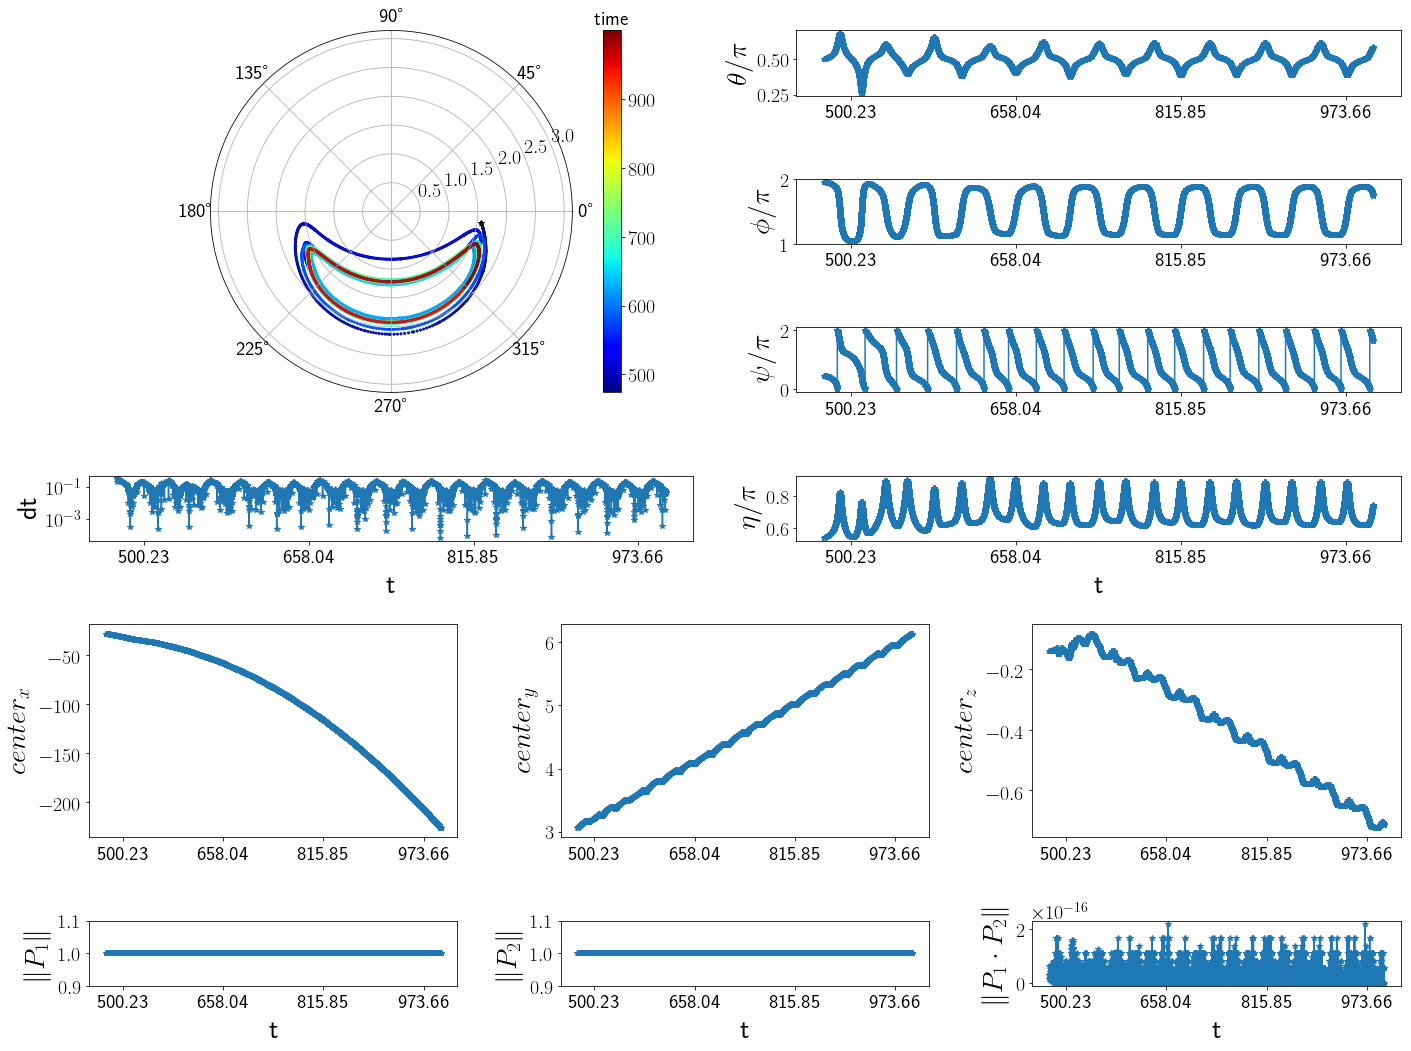

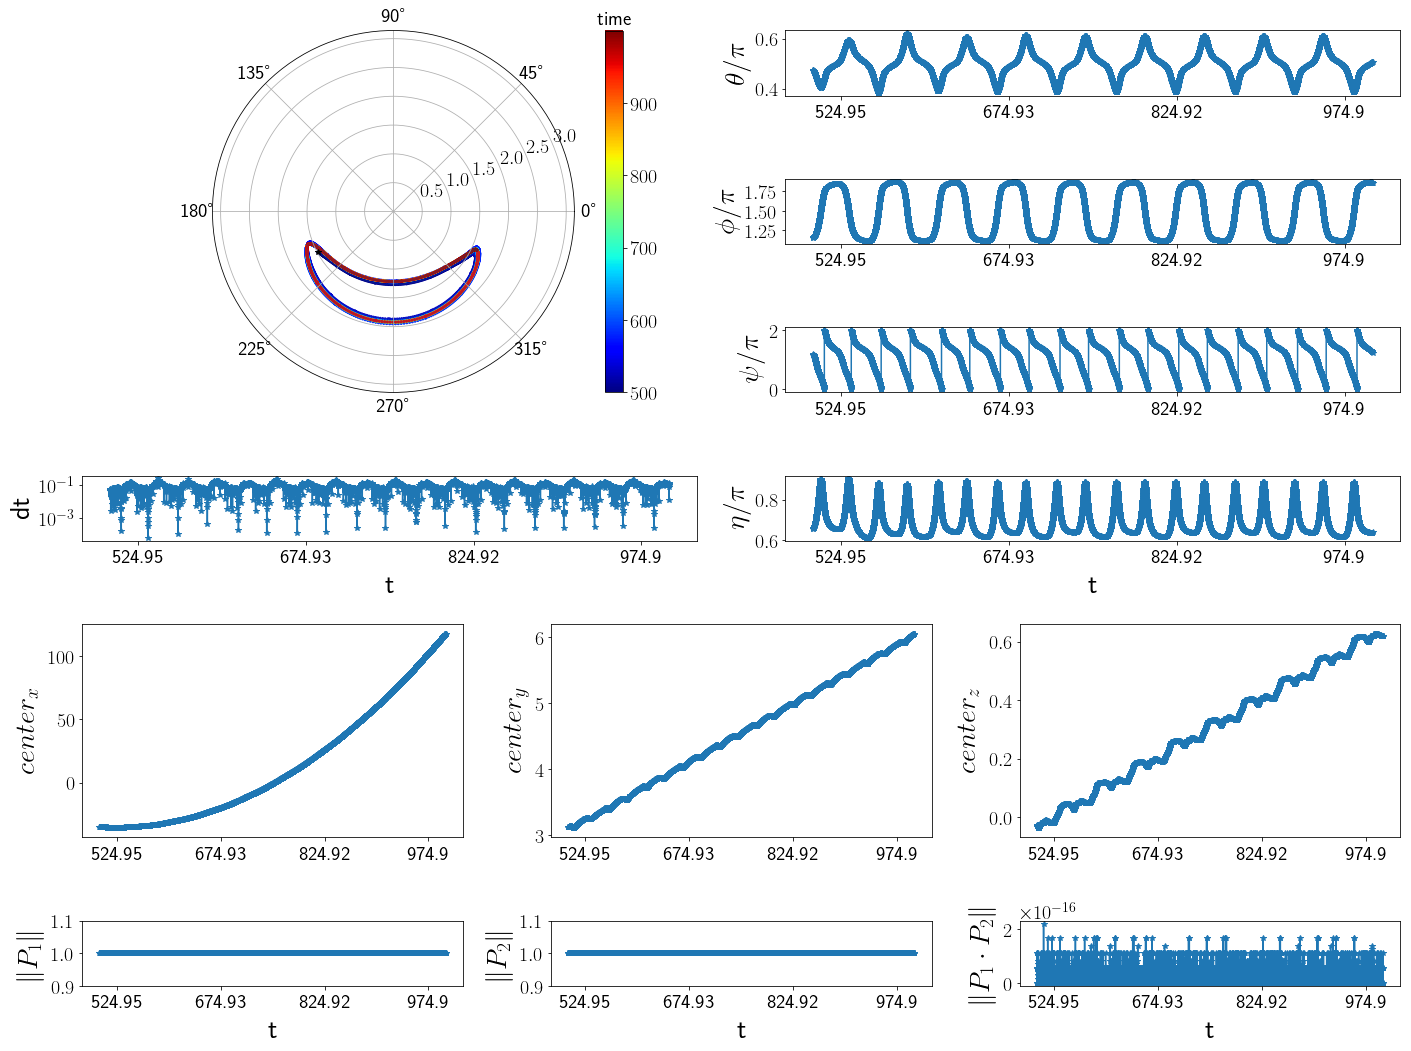

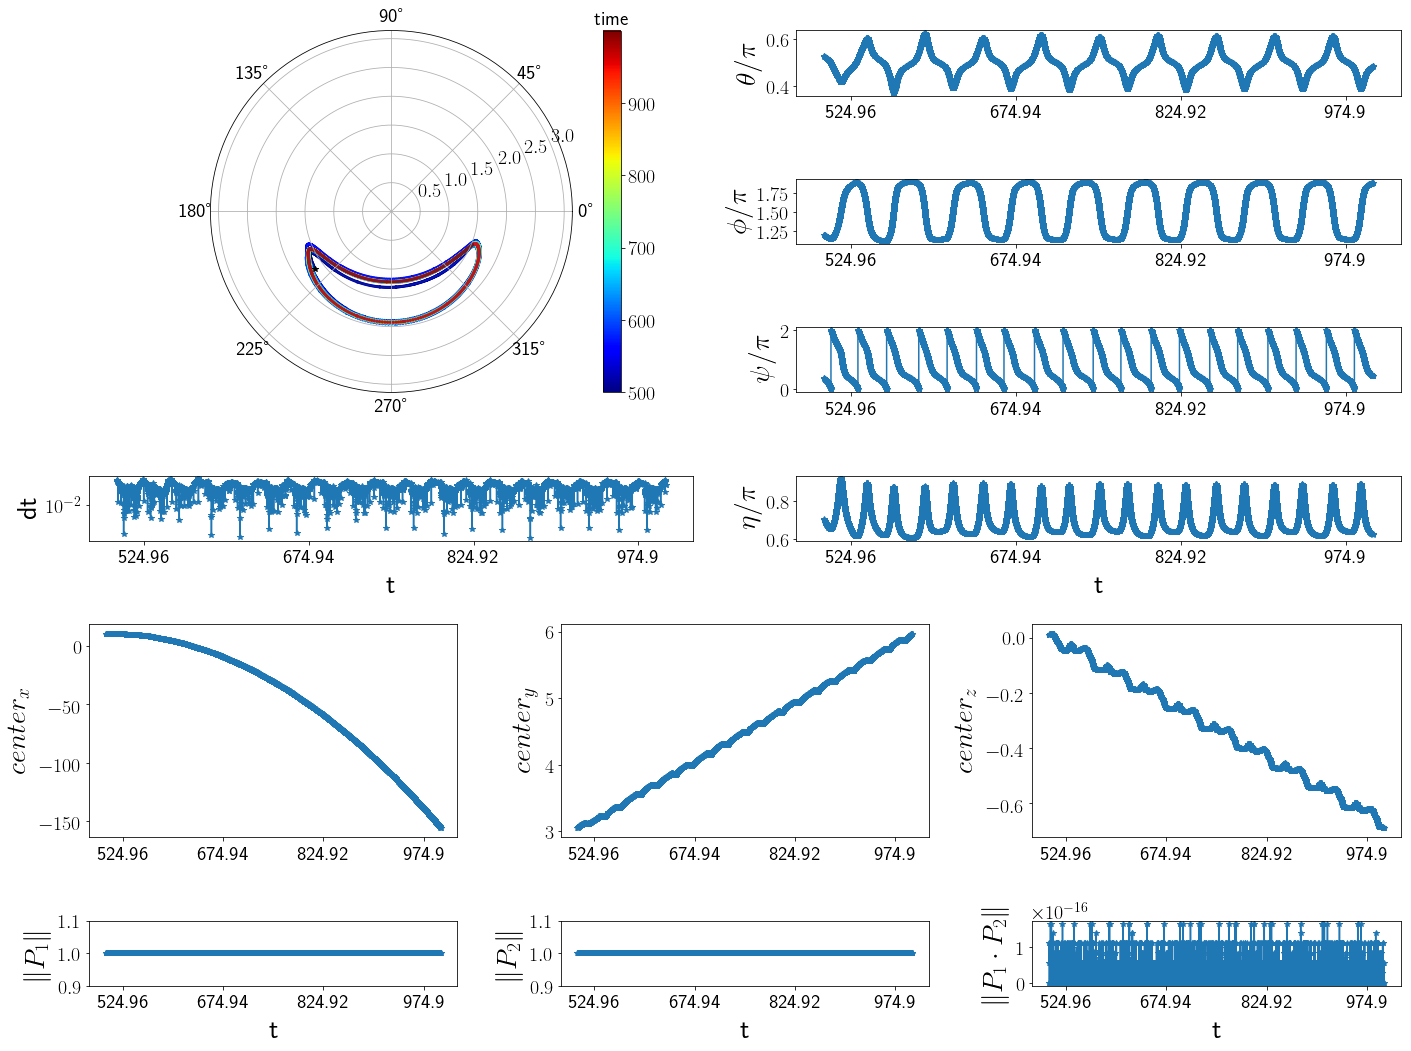

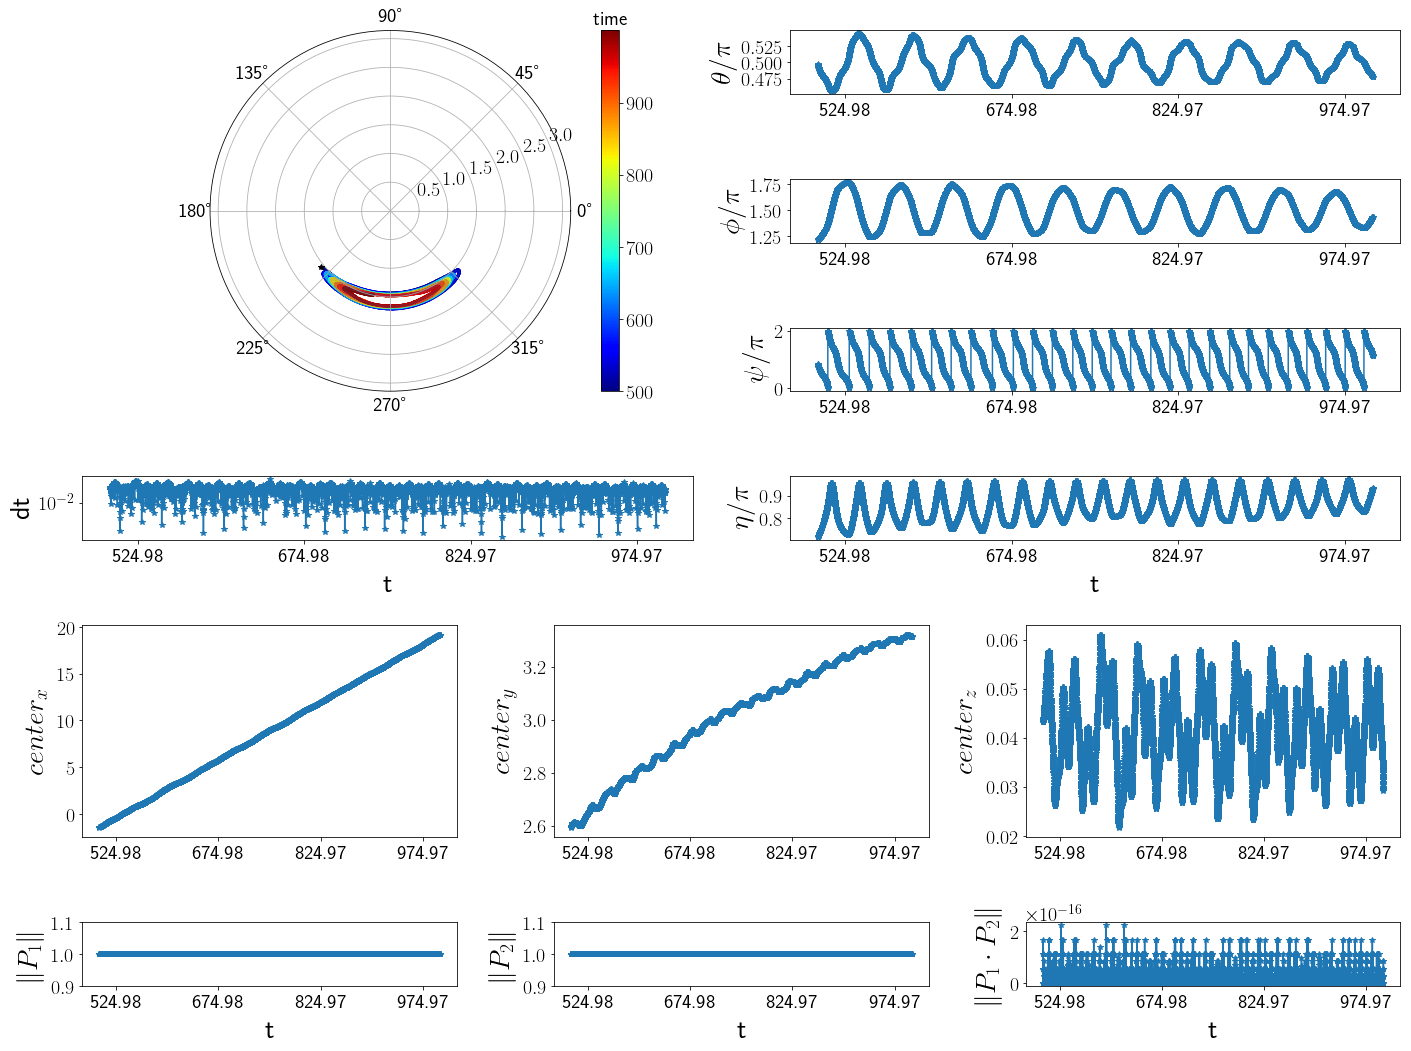

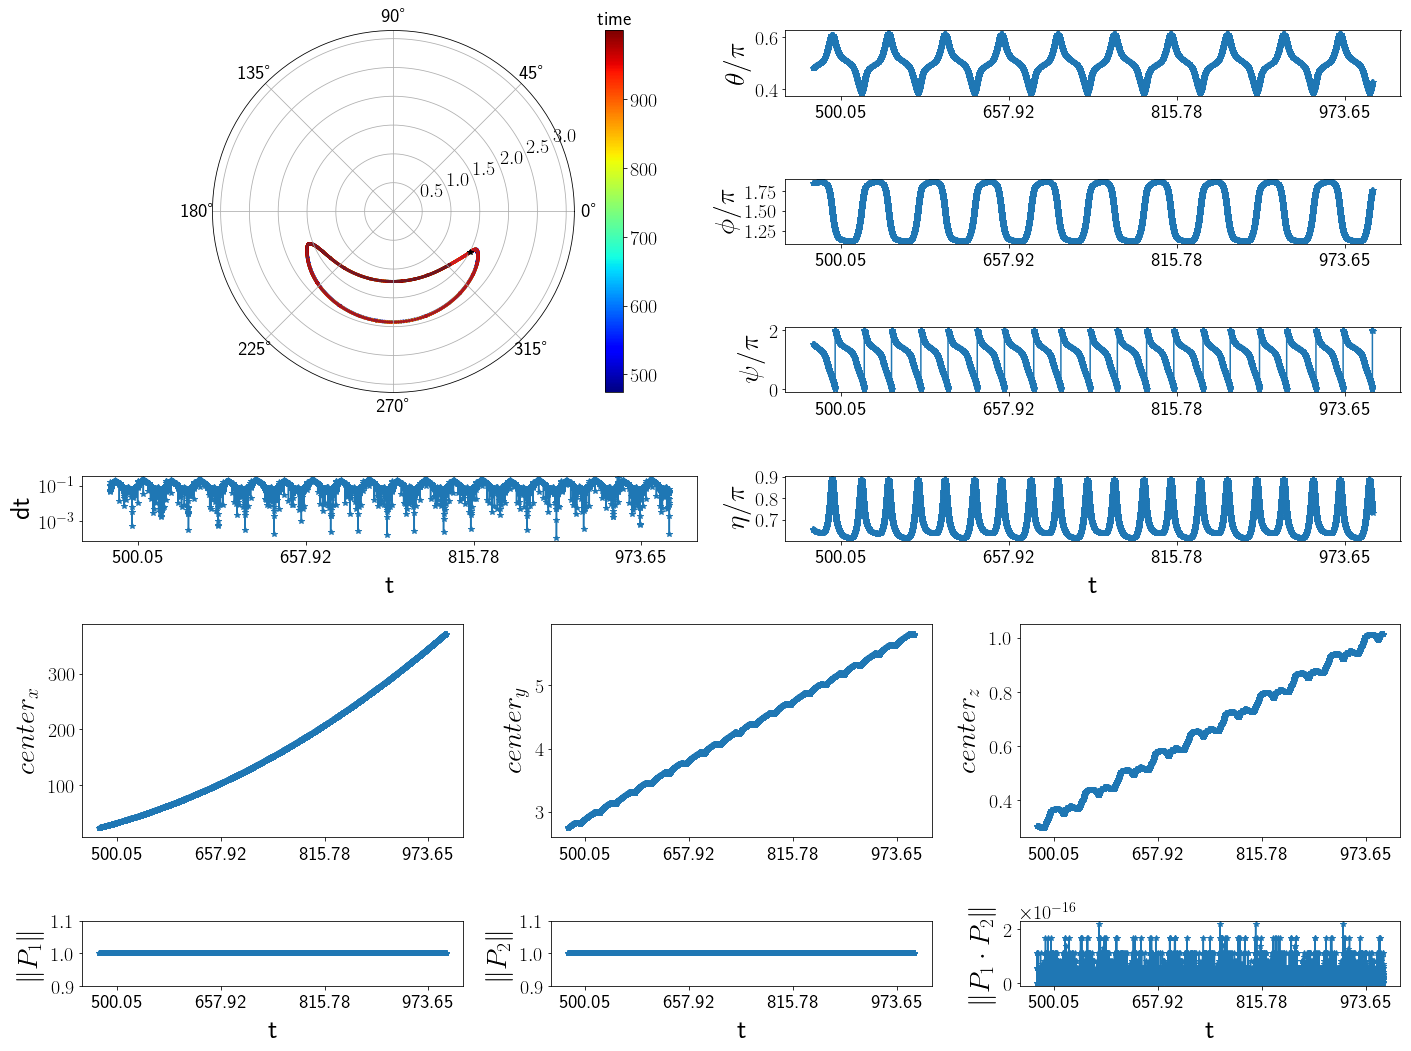

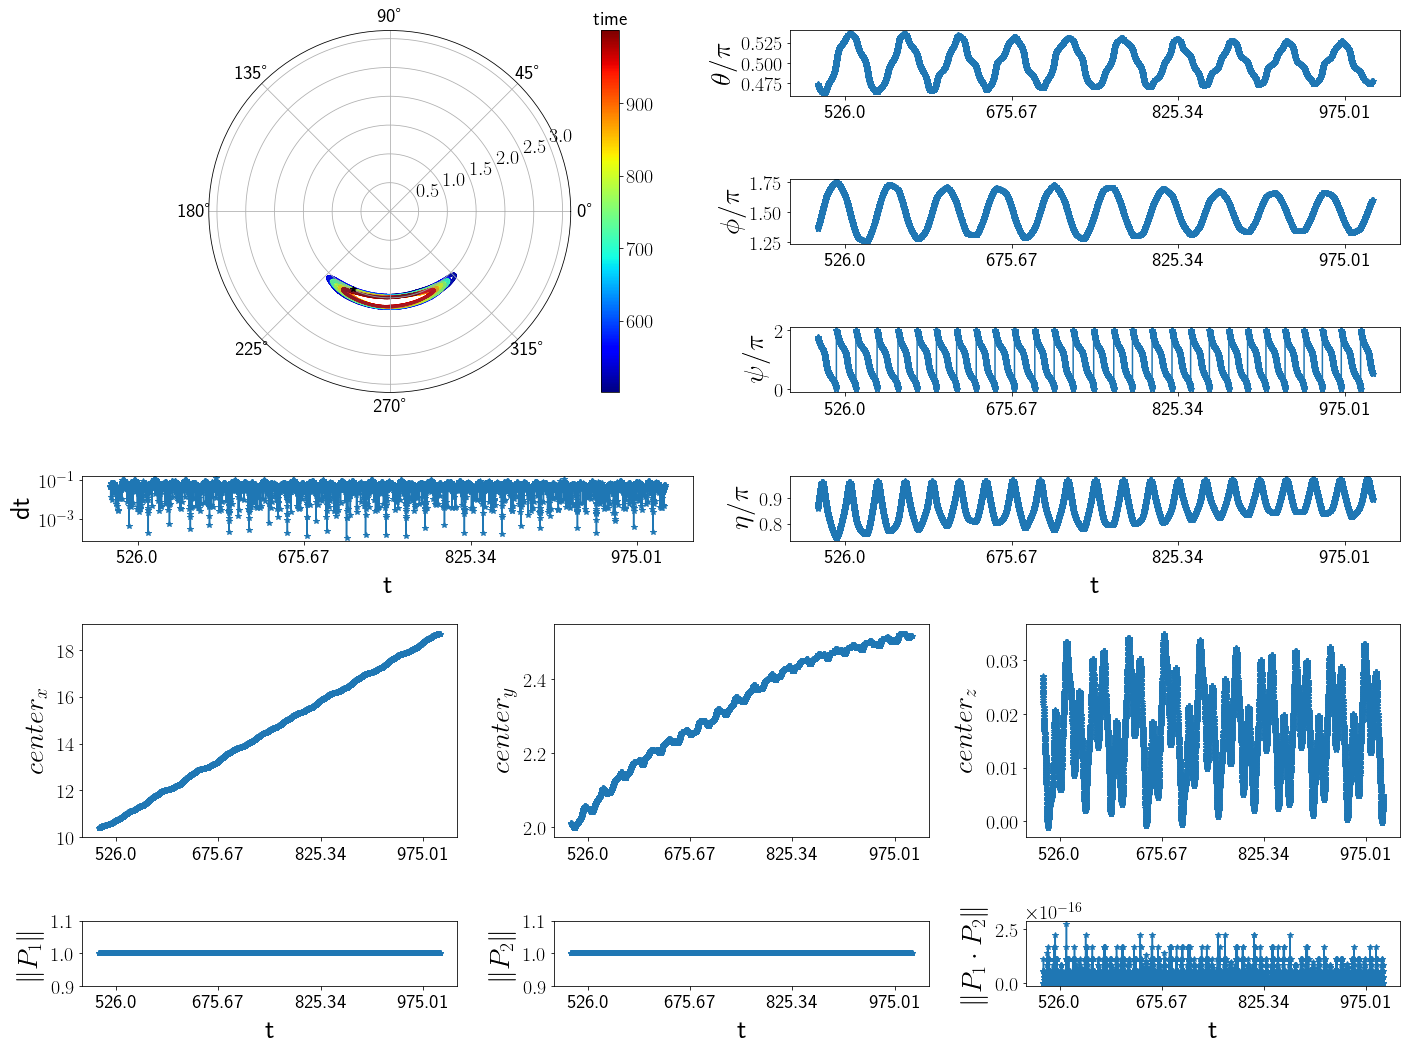

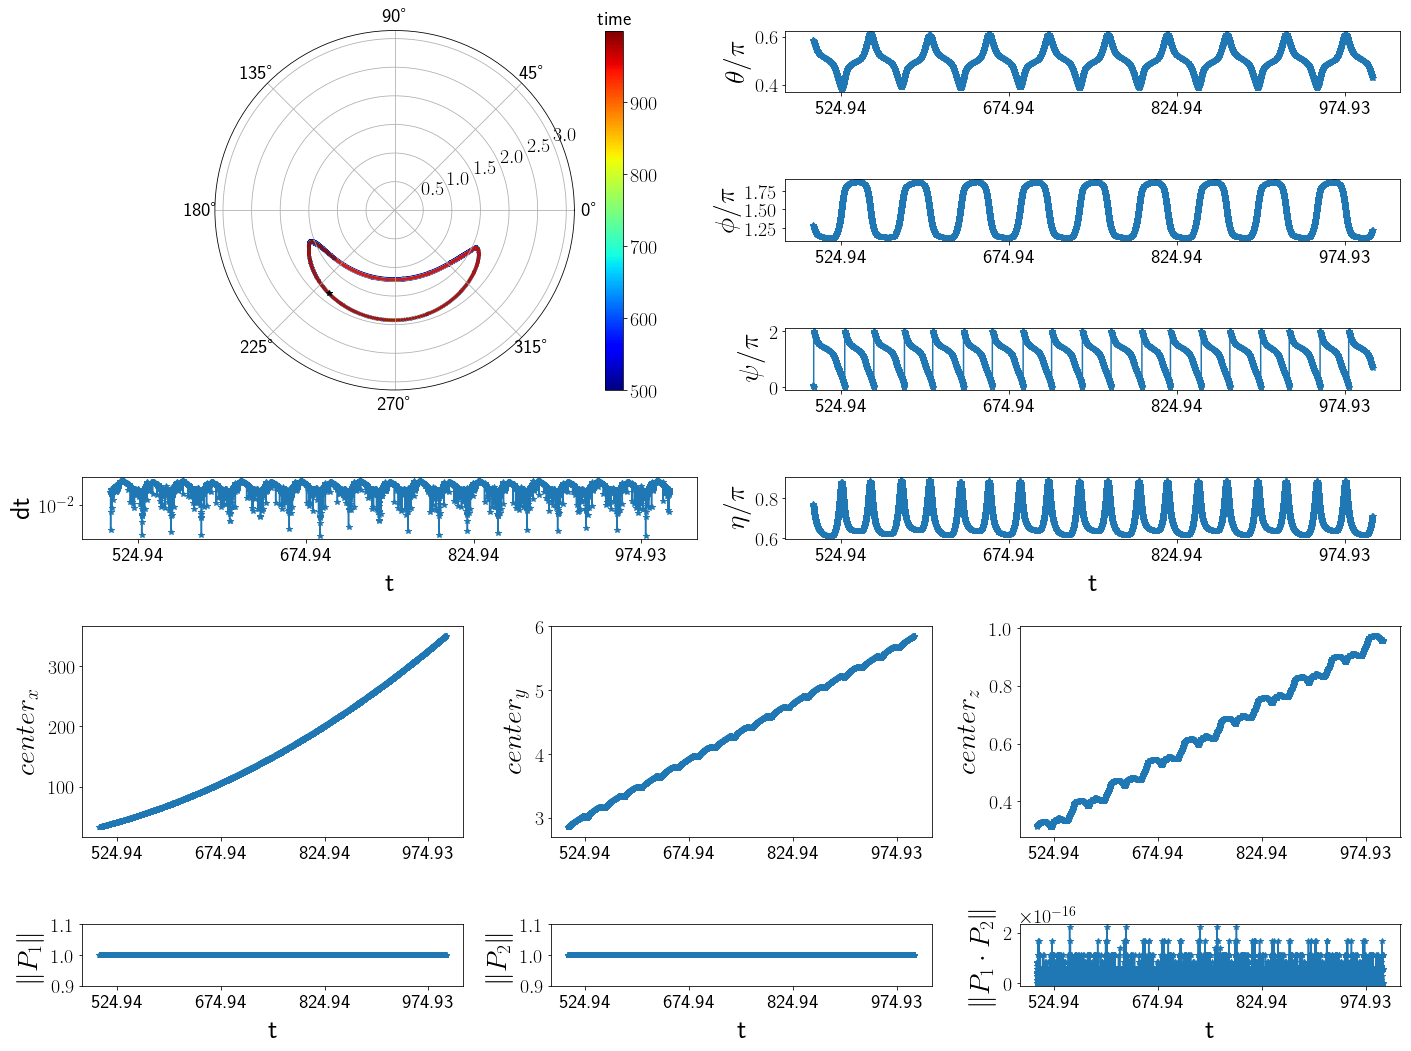

In [251]:
importlib.reload(spf_tb)
show_tlabel = 0

for theta, phi in zip(np.array(ini_theta_list)[tlabels==show_tlabel][:10], 
                         np.array(ini_phi_list)[tlabels==show_tlabel][:10]): 
    spf_tb.show_pickle_results(job_dir, theta, phi, table_name, fast_mode=1)


-ini_theta 0.819546 -ini_phi 1.604218 -ini_psi 0.000000
-ini_theta 3.005002 -ini_phi 0.401054 -ini_psi 0.000000
-ini_theta 1.639092 -ini_phi 0.267370 -ini_psi 0.000000
-ini_theta 3.141592 -ini_phi 0.334212 -ini_psi 0.000000
-ini_theta 2.595229 -ini_phi 2.807381 -ini_psi 0.000000
-ini_theta 2.458638 -ini_phi 3.074750 -ini_psi 0.000000


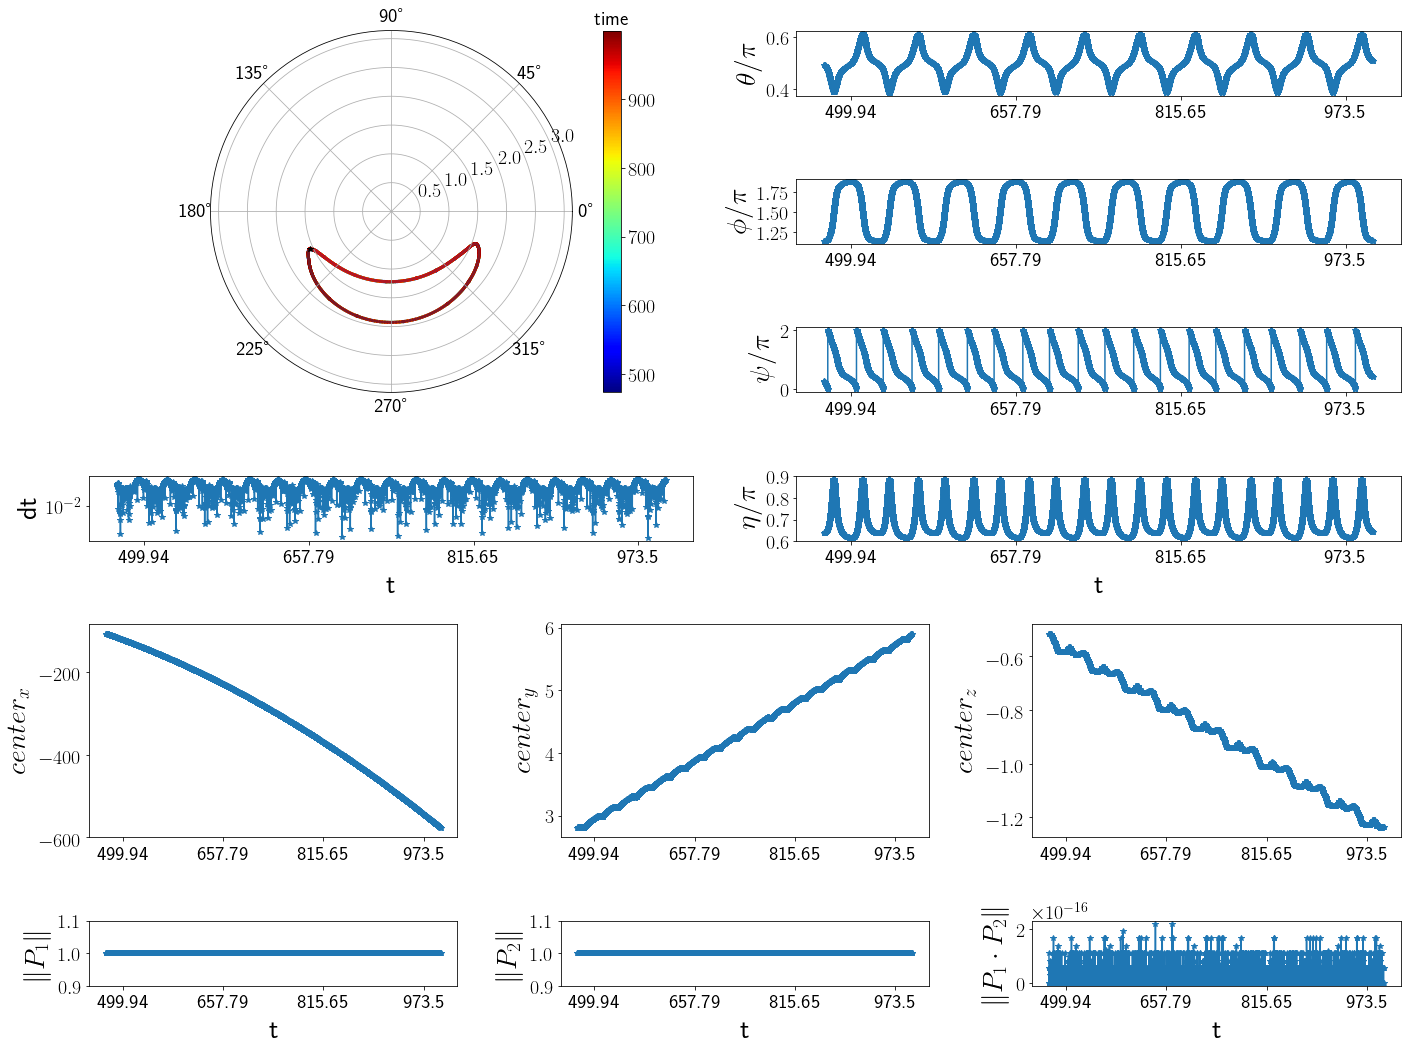

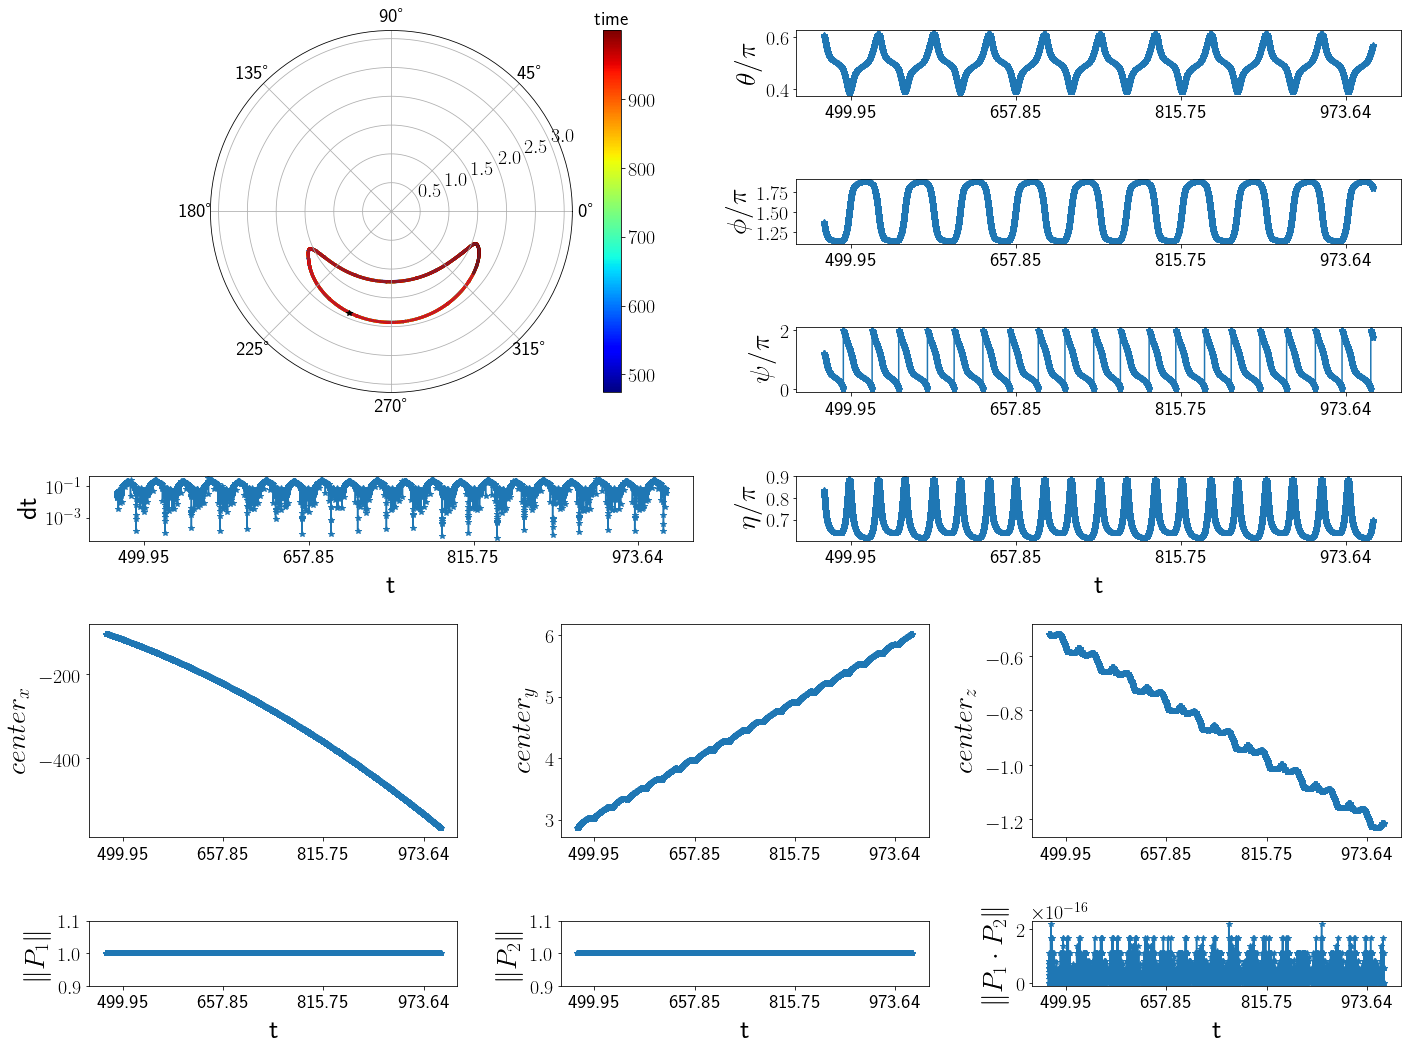

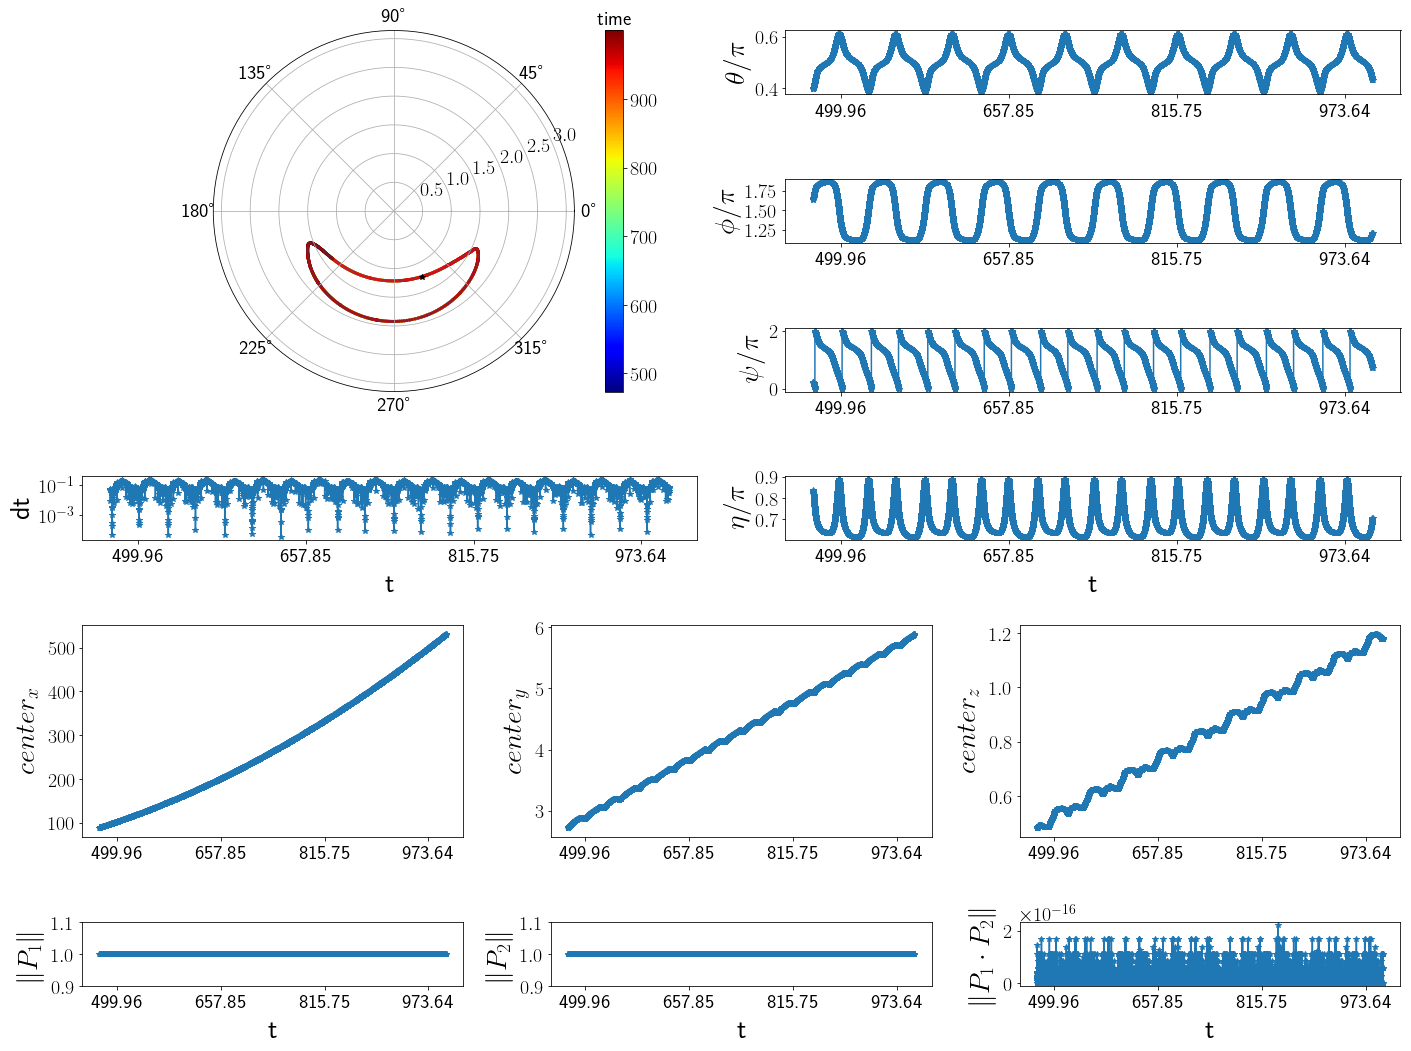

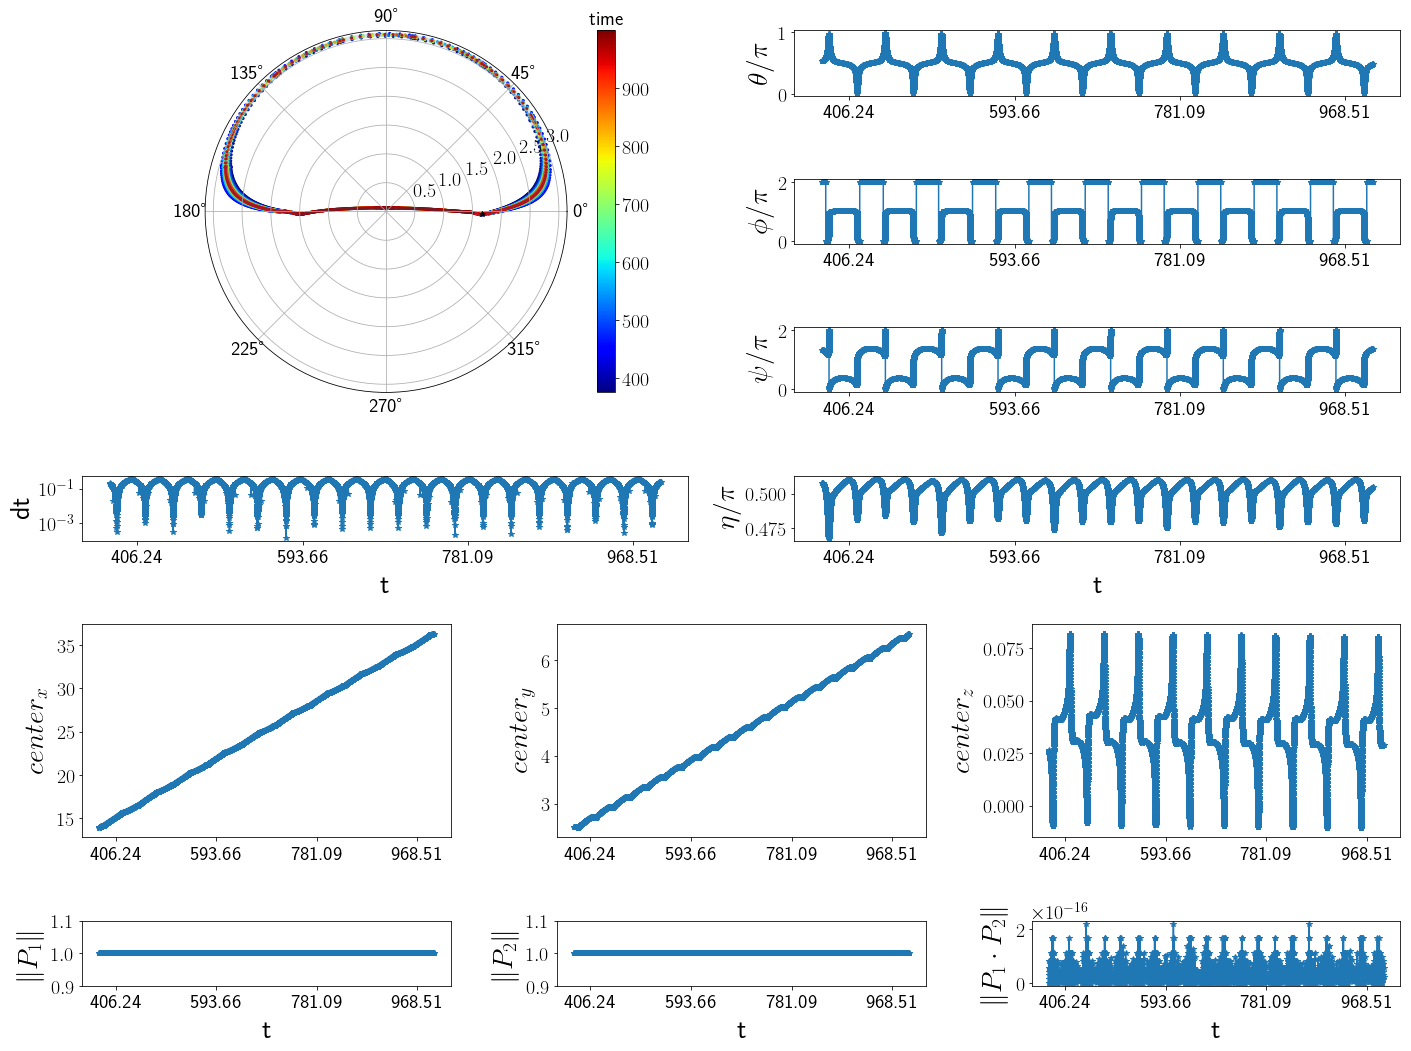

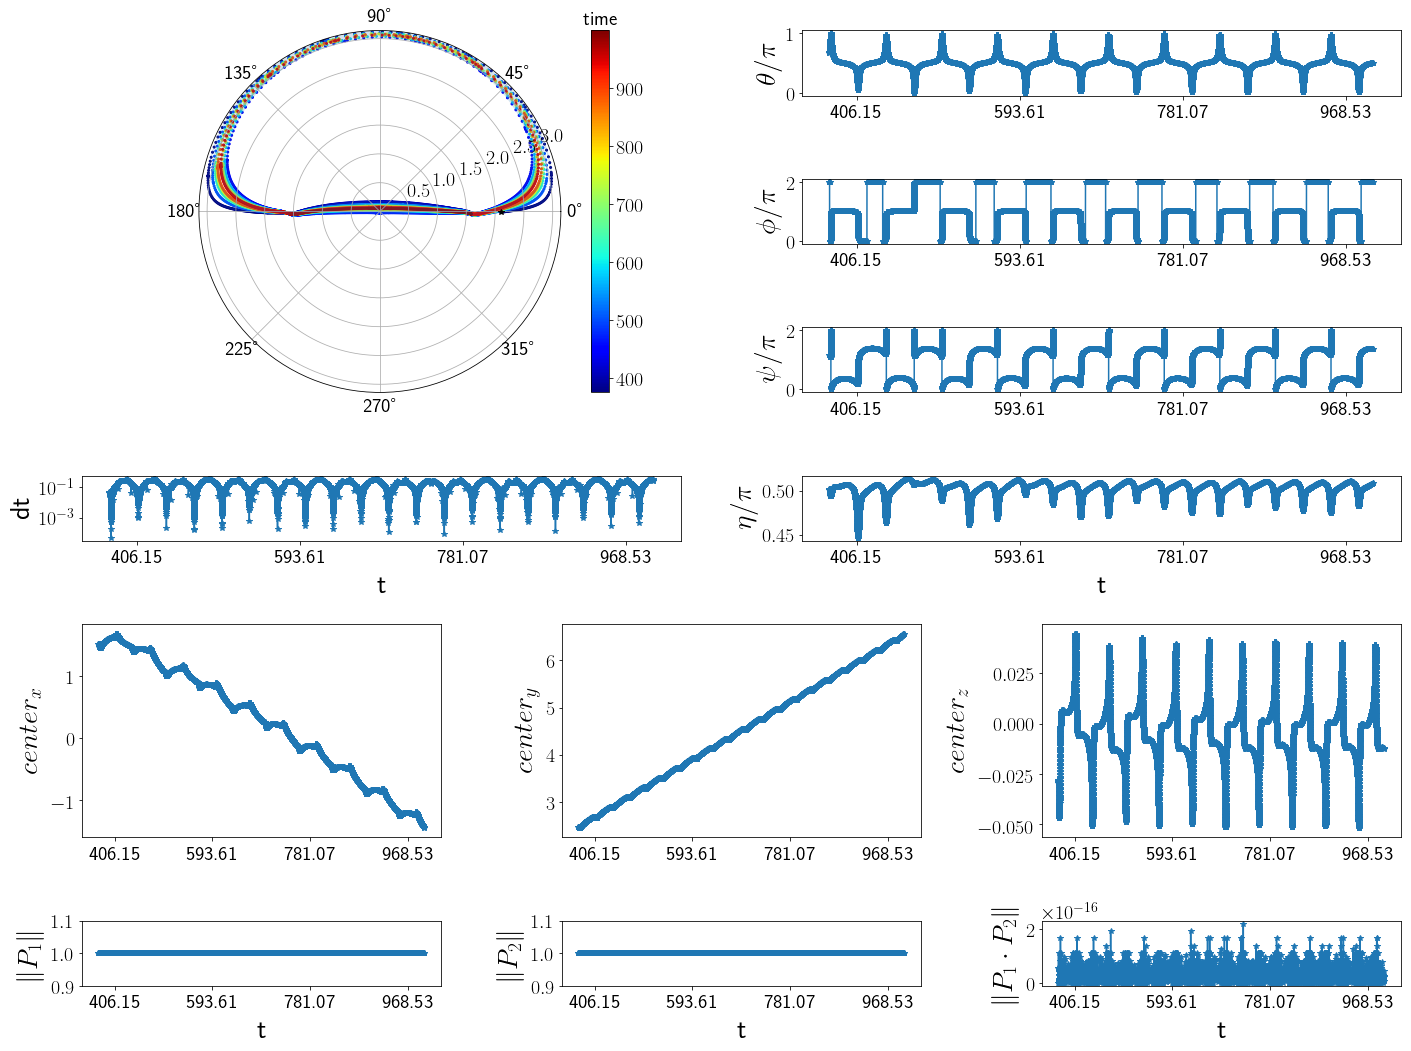

In [241]:
importlib.reload(spf_tb)

for show_tlabel in np.arange(tlabels.max()+1): 
    theta = np.array(ini_theta_list)[tlabels==show_tlabel][0]
    phi = np.array(ini_phi_list)[tlabels==show_tlabel][0]
    spf_tb.show_pickle_results(job_dir, theta, phi, table_name, fast_mode=2)

In [ ]:
tlabels=